# CREDIT SCORING INDIVIDUAL PROJECT BY ENITA OMUVWIE

In [12]:
# References:
#https://www.kaggle.com/code/gpreda/home-credit-default-risk-extensive-eda
#https://www.kaggle.com/code/kabure/financial-hedging-eda-plotly-charts
#https://github.com/diode-meehai/WOE_IV/blob/main/My_credit_scoring_WOE_IV.ipynb
#https://www.kaggle.com/code/shivamb/homecreditrisk-extensive-eda-baseline-0-772
#https://github.com/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb
#https://www.kaggle.com/code/derrickchua29/feature-engineering-eda-focused
#https://www.kaggle.com/code/mammadabbasli/bank-marketing-campaign

## Data Preparation

In [13]:
# Libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import defaultdict
import seaborn as sns
from matplotlib import rcParams
import datetime as dt
from matplotlib.backends.backend_pdf import PdfPages
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import pickle
import woeBinningPandas as woe # pip install woeBinningPandas
from pandas import Series, DataFrame
import pandas.core.algorithms as algos

import plotly.tools as tls
import plotly.offline as py
from chart_studio import plotly
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import warnings

##### Instantiate Machine Learning Models
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import metrics
import eli5
from eli5.sklearn import PermutationImportance
from scipy import stats
from sklearn import metrics
#from sklearn.linear_model import Ridge
#from yellowbrick.regressor import PredictionError, ResidualsPlot
import lightgbm as lgb

%matplotlib inline

# figure size in inches
rcParams['figure.figsize'] = 12,6


In [14]:
# Definition to plot data
def bar_hor(df, col, title, color, w=None, h=None, lm=0, limit=100, return_trace=False, rev=False, xlb = False):
    cnt_srs = df[col].value_counts()
    yy = cnt_srs.head(limit).index[::-1] 
    xx = cnt_srs.head(limit).values[::-1] 
    if rev:
        yy = cnt_srs.tail(limit).index[::-1] 
        xx = cnt_srs.tail(limit).values[::-1] 
    if xlb:
        trace = go.Bar(y=xlb, x=xx, orientation = 'h', marker=dict(color=color))
    else:
        trace = go.Bar(y=yy, x=xx, orientation = 'h', marker=dict(color=color))
    if return_trace:
        return trace 
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def bar_hor_noagg(x, y, title, color, w=None, h=None, lm=0, limit=100, rt=False):
    trace = go.Bar(y=x, x=y, orientation = 'h', marker=dict(color=color))
    if rt:
        return trace
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)


def bar_ver_noagg(x, y, title, color, w=None, h=None, lm=0, rt = False):
    trace = go.Bar(y=y, x=x, marker=dict(color=color))
    if rt:
        return trace
    layout = dict(title=title, margin=dict(l=lm), width=w, height=h)
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
def gp(col, title):
    df1 = accept[accept["Default"] == 1]
    df0 = accept[accept["Default"] == 0]
    a1 = df1[col].value_counts()
    b1 = df0[col].value_counts()
    
    total = dict(accept[col].value_counts())
    x0 = a1.index
    x1 = b1.index
    
    y0 = [float(x)*100 / total[x0[i]] for i,x in enumerate(a1.values)]
    y1 = [float(x)*100 / total[x1[i]] for i,x in enumerate(b1.values)]

    trace1 = go.Bar(x=a1.index, y=y0, name='Target : 1', marker=dict(color="#96D38C"))
    trace2 = go.Bar(x=b1.index, y=y1, name='Target : 0', marker=dict(color="#FEBFB3"))
    return trace1, trace2 

In [15]:
# Load datasets
accept = pd.read_csv('./RealEstateLoans_accepts.csv')
reject = pd.read_csv('./RealEstateLoans_rejects.csv')

In [16]:
# Check the datasets dimensions
print("Accept Shape", accept.shape)
print("Reject Shape", reject.shape)

Accept Shape (18549, 29)
Reject Shape (9112, 28)


In [17]:
# The data set does have a lot to do with the distribution 
accept.describe() 

,total_income,loan_amount,term,interest_rate,nr_children,region_population_ratio,days_birth,days_employed,days_registration,mobile_number,...,days_phone_change,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,Default
count,1.854900e+04,1.854900e+04,18549.000000,18549.000000,18549.000000,18549.000000,18549.000000,18549.000000,18549.000000,18549.0,...,18549.000000,18549.000000,8134.000000,18516.000000,14909.000000,18549.000000,18549.000000,18549.000000,18549.000000,18549.000000
mean,1.689246e+05,6.254865e+05,31.553938,3.357800,0.407300,0.020854,-16092.768667,66052.318939,-5012.563642,1.0,...,-979.131867,2.145992,0.501452,0.512938,0.508383,0.000054,0.781983,0.000054,0.014826,0.085449
std,9.984041e+04,4.031977e+05,15.660557,0.603831,0.717471,0.013785,4338.035246,143162.610715,3521.844669,0.0,...,832.280017,0.905339,0.210804,0.192903,0.195038,0.007342,0.412910,0.007342,0.120858,0.279557
min,2.655000e+04,4.500000e+04,12.000000,0.607395,0.000000,0.000533,-25184.000000,-17170.000000,-19513.000000,1.0,...,-4173.000000,1.000000,0.019207,0.000012,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.125000e+05,2.956680e+05,18.000000,2.991659,0.000000,0.010006,-19734.000000,-2814.000000,-7496.000000,1.0,...,-1593.000000,2.000000,0.334737,0.389382,0.368969,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.575000e+05,5.400000e+05,30.000000,3.401064,0.000000,0.018850,-15786.000000,-1233.000000,-4555.000000,1.0,...,-789.000000,2.000000,0.505589,0.565174,0.531686,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2.025000e+05,8.356050e+05,42.000000,3.777666,1.000000,0.028663,-12483.000000,-272.000000,-2026.000000,1.0,...,-281.000000,3.000000,0.673512,0.664590,0.665855,0.000000,1.000000,0.000000,0.000000,0.000000
max,3.600000e+06,4.050000e+06,60.000000,5.350335,10.000000,0.072508,-7691.000000,365243.000000,0.000000,1.0,...,0.000000,12.000000,0.941433,0.855000,0.887664,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# The data set does have a lot to do with the distribution 
reject.describe()

,total_income,loan_amount,term,interest_rate,nr_children,region_population_ratio,days_birth,days_employed,days_registration,mobile_number,...,email,days_phone_change,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7
count,9.112000e+03,9.112000e+03,9112.000000,9112.000000,9112.000000,9112.000000,9112.000000,9112.000000,9112.000000,9112.0,...,9112.000000,9112.000000,9112.000000,3839.000000,9096.000000,7300.000000,9112.000000,9112.000000,9112.0,9112.000000
mean,1.663160e+05,6.215363e+05,31.361062,3.374724,0.412752,0.020130,-15914.812445,59800.341637,-4916.963016,1.0,...,0.058933,-946.446335,2.144535,0.481655,0.495091,0.491740,0.000110,0.793020,0.0,0.014706
std,9.274824e+04,3.952357e+05,15.758481,0.600167,0.706729,0.013191,4303.556234,137771.157628,3494.933731,0.0,...,0.235513,813.517603,0.899069,0.216923,0.199261,0.201164,0.010476,0.405163,0.0,0.120379
min,2.925000e+04,4.500000e+04,12.000000,1.109934,0.000000,0.000533,-25195.000000,-15713.000000,-20838.000000,1.0,...,0.000000,-4292.000000,1.000000,0.022099,0.000024,0.000527,0.000000,0.000000,0.0,0.000000
25%,1.125000e+05,3.023078e+05,18.000000,3.007148,0.000000,0.009657,-19442.250000,-2710.250000,-7332.000000,1.0,...,0.000000,-1541.250000,2.000000,0.302434,0.355558,0.337673,0.000000,1.000000,0.0,0.000000
50%,1.485000e+05,5.391000e+05,30.000000,3.416068,0.000000,0.018801,-15601.500000,-1196.500000,-4449.000000,1.0,...,0.000000,-744.500000,2.000000,0.480482,0.549484,0.513694,0.000000,1.000000,0.0,0.000000
75%,2.025000e+05,8.235394e+05,42.000000,3.791639,1.000000,0.026392,-12316.750000,-335.000000,-1930.750000,1.0,...,0.000000,-278.000000,3.000000,0.658210,0.653967,0.656158,0.000000,1.000000,0.0,0.000000
max,2.930026e+06,2.695500e+06,60.000000,5.164508,5.000000,0.072508,-7676.000000,365243.000000,-1.000000,1.0,...,1.000000,0.000000,7.000000,0.933115,0.818576,0.880268,1.000000,1.000000,0.0,1.000000


In [19]:
# Checking information of dataset
print(accept.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18549 entries, 0 to 18548
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   total_income             18549 non-null  float64
 1   loan_amount              18549 non-null  float64
 2   term                     18549 non-null  int64  
 3   interest_rate            18549 non-null  float64
 4   own_car                  18549 non-null  object 
 5   own_house                18549 non-null  object 
 6   nr_children              18549 non-null  int64  
 7   income_type              18549 non-null  object 
 8   education_type           18549 non-null  object 
 9   family_status            18549 non-null  object 
 10  housing_type             18549 non-null  object 
 11  region_population_ratio  18549 non-null  float64
 12  days_birth               18549 non-null  int64  
 13  days_employed            18549 non-null  int64  
 14  days_registration     

In [20]:
# Checking information of dataset
print(reject.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9112 entries, 0 to 9111
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   total_income             9112 non-null   float64
 1   loan_amount              9112 non-null   float64
 2   term                     9112 non-null   int64  
 3   interest_rate            9112 non-null   float64
 4   own_car                  9112 non-null   object 
 5   own_house                9112 non-null   object 
 6   nr_children              9112 non-null   int64  
 7   income_type              9112 non-null   object 
 8   education_type           9112 non-null   object 
 9   family_status            9112 non-null   object 
 10  housing_type             9112 non-null   object 
 11  region_population_ratio  9112 non-null   float64
 12  days_birth               9112 non-null   int64  
 13  days_employed            9112 non-null   int64  
 14  days_registration       

In [21]:
# Checking columns of dataset
accept.columns

Index(['total_income', 'loan_amount', 'term', 'interest_rate', 'own_car',
       'own_house', 'nr_children', 'income_type', 'education_type',
       'family_status', 'housing_type', 'region_population_ratio',
       'days_birth', 'days_employed', 'days_registration', 'mobile_number',
       'phone_number', 'email', 'days_phone_change', 'occupation_type',
       'family_count', 'EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7',
       'Default'],
      dtype='object')

In [22]:
## Univariate analysis (Default)
df_target = accept[['Default']]
df_target['Default'] = np.where(df_target['Default']==1,'Bad','Good')

print(df_target['Default'].value_counts())
print('*'*40)
print(df_target['Default'].value_counts()/len(df_target)*100)
print('*'*40)

## IR = (negative_class/positive_class)
## Where positive_class is the number of minority class samples and negative_class is the number of majority class samples

count_good = len(df_target.loc[df_target['Default']=='Good'])
count_bad = len(df_target.loc[df_target['Default']=='Bad'])

print("Imbalance Ratio (IR) = 1:{}".format(int(count_good/count_bad)))

Good    16964
Bad      1585
Name: Default, dtype: int64
****************************************
Good    91.455065
Bad      8.544935
Name: Default, dtype: float64
****************************************
Imbalance Ratio (IR) = 1:10


C:\Users\eomuvwie\AppData\Local\Temp/ipykernel_24268/260144424.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
# Target Variable Distribution 
bar_hor(accept, "Default", "Distribution of Target Variable" , ["#008000", '#ff4444'], h=350, w=600, lm=200, xlb = ['Target : 1','Target : 0'])

In [24]:
# Checking the distribution of values
accept["Default"].value_counts()

0    16964
1     1585
Name: Default, dtype: int64

In [25]:
# Function to give a statistical summary of the data set
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [26]:
# Checking table with function
resumetable(reject)

Dataset Shape: (9112, 28)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,total_income,float64,0,283,270000.0,90000.0,225000.0,5.06
1,loan_amount,float64,0,1879,888840.0,562491.0,790830.0,9.10
2,term,int64,0,9,48,36,48,3.01
3,interest_rate,float64,0,9112,2.344399,3.195584,3.156887,13.15
4,own_car,object,0,2,N,N,Y,0.92
5,own_house,object,0,2,Y,Y,Y,0.90
6,nr_children,int64,0,6,1,0,0,1.22
7,income_type,object,0,4,Commercial associate,Working,Working,1.66
8,education_type,object,0,5,Higher education,Secondary / secondary special,Secondary / secondary special,1.05
9,family_status,object,0,5,Married,Married,Single / not married,1.64


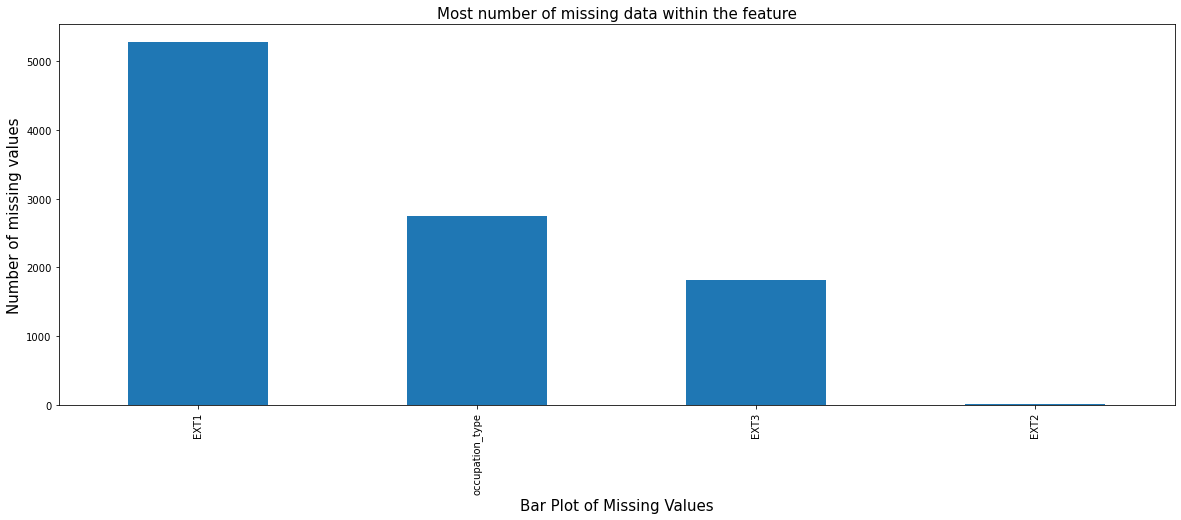

In [27]:
# Plotting Missing Values
plt.figure(figsize=(20,7))
missing= reject.isnull().sum()
missing= missing[missing > 0]
missing.sort_values(ascending= False, inplace=True)
plt.xlabel("Bar Plot of Missing Values", fontsize=15)
plt.ylabel("Number of missing values", fontsize=15)
plt.title("Most number of missing data within the feature", fontsize=15)
missing[:80].plot(kind="bar")

plt.show()

In [28]:
# Checking table with function
resumetable(accept)

Dataset Shape: (18549, 29)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,total_income,float64,0,434,157500.0,76500.0,67500.0,5.10
1,loan_amount,float64,0,2435,288562.5,225000.0,409653.0,9.23
2,term,int64,0,9,30,48,12,3.02
3,interest_rate,float64,0,18549,3.737395,3.6543,3.262865,14.18
4,own_car,object,0,2,Y,N,Y,0.93
5,own_house,object,0,2,N,Y,N,0.90
6,nr_children,int64,0,9,0,3,0,1.21
7,income_type,object,0,6,Commercial associate,Working,Working,1.71
8,education_type,object,0,5,Secondary / secondary special,Secondary / secondary special,Secondary / secondary special,1.07
9,family_status,object,0,5,Married,Separated,Civil marriage,1.62


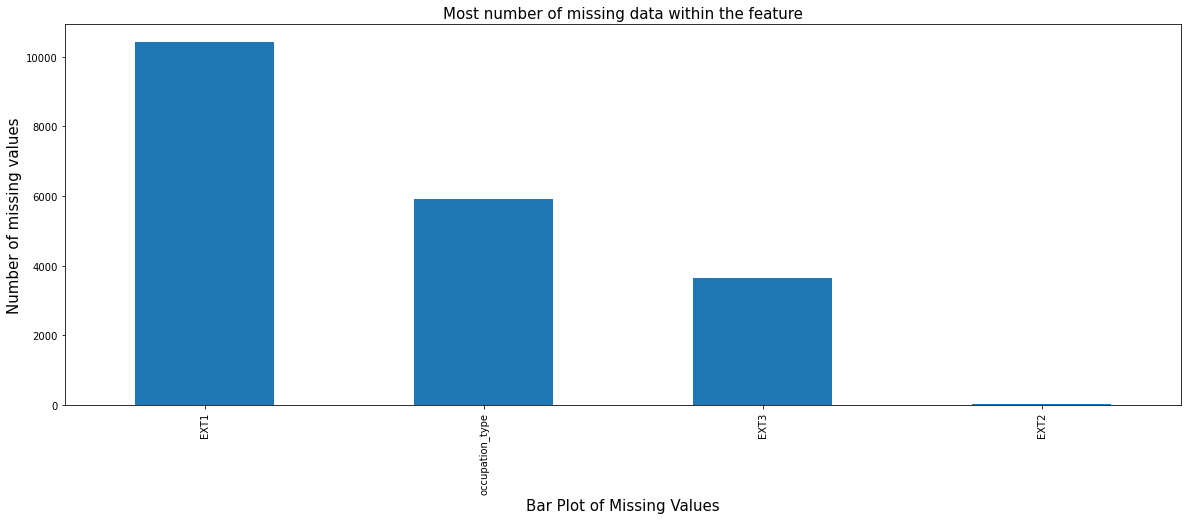

In [29]:
# Plotting Missing Values
plt.figure(figsize=(20,7))
missing= accept.isnull().sum()
missing= missing[missing > 0]
missing.sort_values(ascending= False, inplace=True)
plt.xlabel("Bar Plot of Missing Values", fontsize=15)
plt.ylabel("Number of missing values", fontsize=15)
plt.title("Most number of missing data within the feature", fontsize=15)
missing[:80].plot(kind="bar")

plt.show()

In [30]:
# Function for filling missing values
def fill_missing(df):
    for col in df.columns:
        
        # Check object
        if  df[col].dtypes == np.object :
            print('object: ', df[col])
            df[col] = df[col].fillna(value='Unidentified')
            
        
        # Check number
        elif df[col].dtypes == np.number:
            print('number: ', df[col])
            df[col] = df[col].fillna(df[col].median()) 
            
            

    return df

In [31]:
# Applying function
accept = fill_missing(accept)

number:  0        157500.0
1         76500.0
2         67500.0
3        180000.0
4        130500.0
           ...   
18544     90000.0
18545    184500.0
18546    157500.0
18547    157500.0
18548    157500.0
Name: total_income, Length: 18549, dtype: float64
number:  0         288562.5
1         225000.0
2         409653.0
3         328405.5
4        1225224.0
           ...    
18544     101880.0
18545    1686591.0
18546     203760.0
18547     348264.0
18548     675000.0
Name: loan_amount, Length: 18549, dtype: float64
number:  0        3.737395
1        3.654300
2        3.262865
3        4.773736
4        2.867961
           ...   
18544    3.433528
18545    2.372974
18546    4.155449
18547    2.694917
18548    4.340496
Name: interest_rate, Length: 18549, dtype: float64
object:  0        Y
1        N
2        Y
3        Y
4        N
        ..
18544    N
18545    Y
18546    N
18547    Y
18548    Y
Name: own_car, Length: 18549, dtype: object
object:  0        N
1        Y
2        N
3 

C:\Users\eomuvwie\AppData\Local\Temp/ipykernel_24268/996280131.py:6: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\eomuvwie\AppData\Local\Temp/ipykernel_24268/996280131.py:12: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



In [32]:
# Applying function
reject = fill_missing(reject)

number:  0       270000.0
1        90000.0
2       225000.0
3       135000.0
4        67500.0
          ...   
9107    112500.0
9108     67500.0
9109    157500.0
9110    180000.0
9111    157500.0
Name: total_income, Length: 9112, dtype: float64
number:  0       888840.0
1       562491.0
2       790830.0
3       900000.0
4       808650.0
          ...   
9107    539100.0
9108    207396.0
9109    641529.0
9110    738486.0
9111    170640.0
Name: loan_amount, Length: 9112, dtype: float64
number:  0       2.344399
1       3.195584
2       3.156887
3       3.472026
4       2.610668
          ...   
9107    1.806103
9108    3.864475
9109    3.262304
9110    3.728453
9111    3.773489
Name: interest_rate, Length: 9112, dtype: float64
object:  0       N
1       N
2       Y
3       N
4       N
       ..
9107    N
9108    N
9109    N
9110    N
9111    Y
Name: own_car, Length: 9112, dtype: object
object:  0       Y
1       Y
2       Y
3       N
4       N
       ..
9107    N
9108    Y
9109    Y
9110

C:\Users\eomuvwie\AppData\Local\Temp/ipykernel_24268/996280131.py:6: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\eomuvwie\AppData\Local\Temp/ipykernel_24268/996280131.py:12: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.



In [33]:
# Checking if any categorical Features are there in the Dataset
categorical_data = accept.select_dtypes(exclude=[np.number])
print ("There are {} categorical Columns in Dataset".format(categorical_data.shape[1]))

There are 7 categorical Columns in Dataset


In [34]:
# Name of all the Categorical Features Present in the Dataset
categorical_data.any()

own_car            True
own_house          True
income_type        True
education_type     True
family_status      True
housing_type       True
occupation_type    True
dtype: bool

## Exploratory Data Analysis

In [35]:
# Plotting a graph with comparison to the target variable distribution
tr0 = bar_hor(accept, "own_car", "Distribution of own_car Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('own_car', 'Distribution of Target with Applicant Car')

fig = tls.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["Car Distribution" , "car, Target=1" ,"Car, Target=0"])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig.append_trace(tr2, 1, 3);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=50));
iplot(fig);

C:\tools\Anaconda3\envs\py\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [36]:
# Plotting a graph with comparison to the target variable distribution
tr0 = bar_hor(accept, "family_status", "Distribution of Family Status Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1, tr2 = gp('family_status', 'Distribution of Target with Applicant Family Status')

fig = tls.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles = ["Family Status Distribution" , "Family Status, Target = 1" ,"Family Status, Target = 0"])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig.append_trace(tr2, 1, 3);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);

In [37]:
## # Plotting a graph with comparison to the target variable distribution 
t = accept['own_house'].value_counts()
labels = t.index
values = t.values
colors = ['#96D38C','#FEBFB3']
trace = go.Pie(labels=labels, values=values,
               textfont=dict(size=12),
               marker=dict(colors=colors,
                           line=dict(color='#fff', width=2)))
layout = go.Layout(title='Applicants Owning House', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

t = accept['own_car'].value_counts()
labels = t.index
values = t.values
colors = ['#FEBFB3','#96D38C']
trace = go.Pie(labels=labels, values=values,
               textfont=dict(size=12),
               marker=dict(colors=colors,
                           line=dict(color='#fff', width=2)))
layout = go.Layout(title='Applicants Owning Car', height=400)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


tr1, tr2 = gp('own_house', 'Applicants Owning Real Estate wrt Target Variable')
tr3, tr4 = gp('own_car', 'Applicants Owning Car wrt Target Variable')
fig = tls.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["% Applicants with House and Target = 1", "% Applicants with Car and Target = 1"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr3, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);


In [38]:
# Plotting a graph with comparison to the target variable distribution
tr0 = bar_hor(accept, "education_type", "Distribution of CODE_GENDER Variable" ,"#f975ae", w=700, lm=100, return_trace= True)
tr1= bar_hor(accept, "income_type", "Distribution of Income Variable" ,"#f975ae", w=700, lm=100, return_trace= True)

fig = tls.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ['Applicants Education Type','Applicants Income Type'])
fig.append_trace(tr0, 1, 1);
fig.append_trace(tr1, 1, 2);
fig['layout'].update(height=400, showlegend=False, margin=dict(l=100));
iplot(fig);

In [39]:
# Plotting a graph with comparison to the target variable distribution
tr1, tr2 = gp('education_type', 'Applicants Education Type which repayed the loan')
fig = tls.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Education Types distribution when Target = 1", "Applicants Education Type distribution when Target = 0"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr2, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);


tr1, tr2 = gp('income_type', 'Applicants Income Types which repayed the loan')
fig = tls.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Income Types when Target = 1", "Applicants Income Type When Target = 0"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr2, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=120));
iplot(fig);

In [40]:
# Plotting a graph with comparison to the target variable distribution
tr1 = bar_hor(accept, "occupation_type", "Distribution of " ,"#f975ae", w=700, lm=100, return_trace= True)
tr2 = bar_hor(accept, "housing_type", "Distribution of " ,"#f975ae", w=700, lm=100, return_trace = True)

fig = tls.make_subplots(rows=1, cols=2, print_grid=False, subplot_titles = ['Applicants Occupation Type', 'Applicants Housing Type' ])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr2, 1, 2);
fig['layout'].update(height=400, showlegend=False, margin=dict(l=100));
iplot(fig);


tr1, tr2 = gp('occupation_type', 'Applicants Income Types which repayed the loan')
tr3, tr4 = gp('housing_type', 'Applicants Income Types which repayed the loan')
fig = tls.make_subplots(rows=1, cols=2, print_grid=False, 
                          subplot_titles = ["Applicants Occupation Types, Target=1", "Applicants Housing Type, Target=1"])
fig.append_trace(tr1, 1, 1);
fig.append_trace(tr3, 1, 2);
fig['layout'].update(height=350, showlegend=False, margin=dict(l=30));
iplot(fig);

In [41]:
# Plotting a graph with comparison to the target variable distribution
percentual_types = round(accept["housing_type"].value_counts(), 2)

types = round(accept["housing_type"].value_counts() / len(accept["housing_type"]) * 100,2)

labels = list(types.index)
values = list(types.values)

trace1 = go.Pie(labels=labels, values=values, marker=dict(colors=['red']), text = percentual_types.values,)

layout = go.Layout(title='Distribuition of Housing Types', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

In [42]:
# Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(accept[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()  

In [43]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = accept.loc[accept['Default'] != 0]
    t0 = accept.loc[accept['Default'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



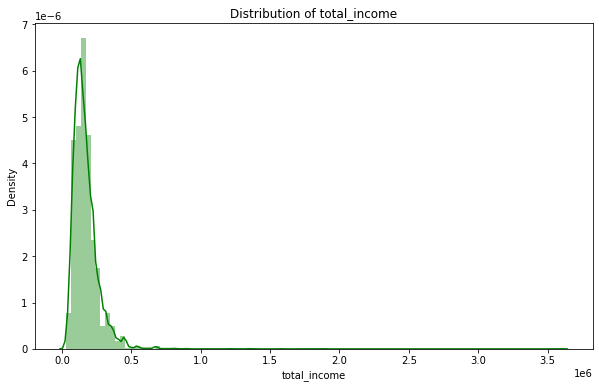

In [44]:
# Plotting a graph of variable distribution
plot_distribution('total_income','green')

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



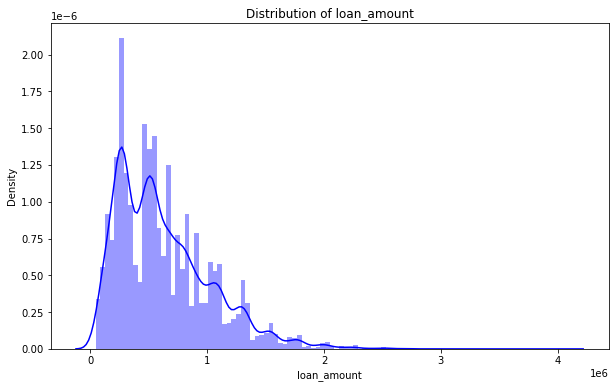

In [45]:
# Plotting a graph of variable distribution
plot_distribution('loan_amount','blue')

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



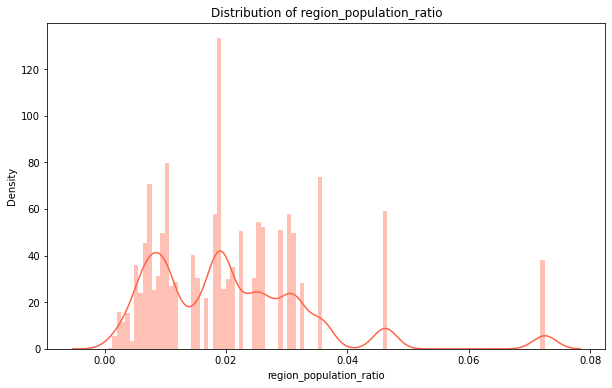

In [46]:
# Plotting a graph of variable distribution
plot_distribution('region_population_ratio','tomato')

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



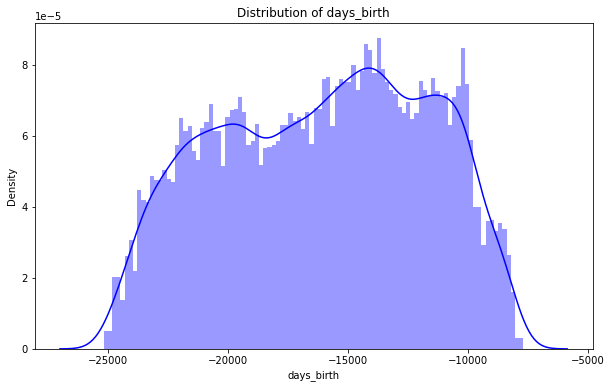

In [47]:
# Plotting a graph of variable distribution
plot_distribution('days_birth','blue')

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



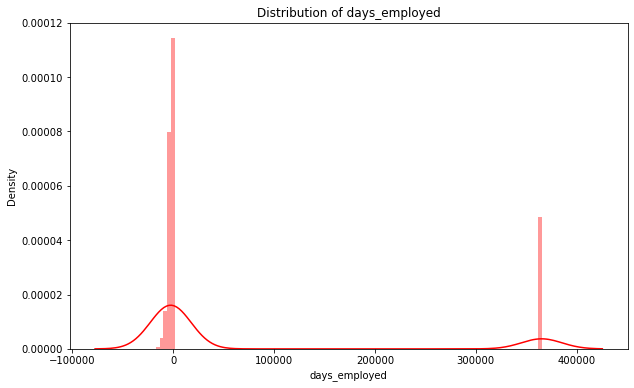

In [48]:
# Plotting a graph of variable distribution
plot_distribution('days_employed','red')

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



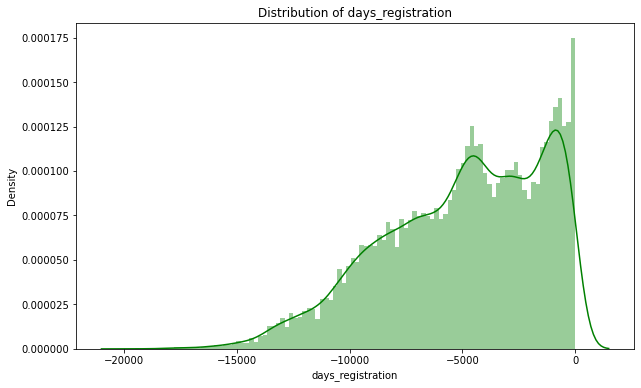

In [49]:
# Plotting a graph of variable distribution
plot_distribution('days_registration','green')

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the

<Figure size 864x432 with 0 Axes>

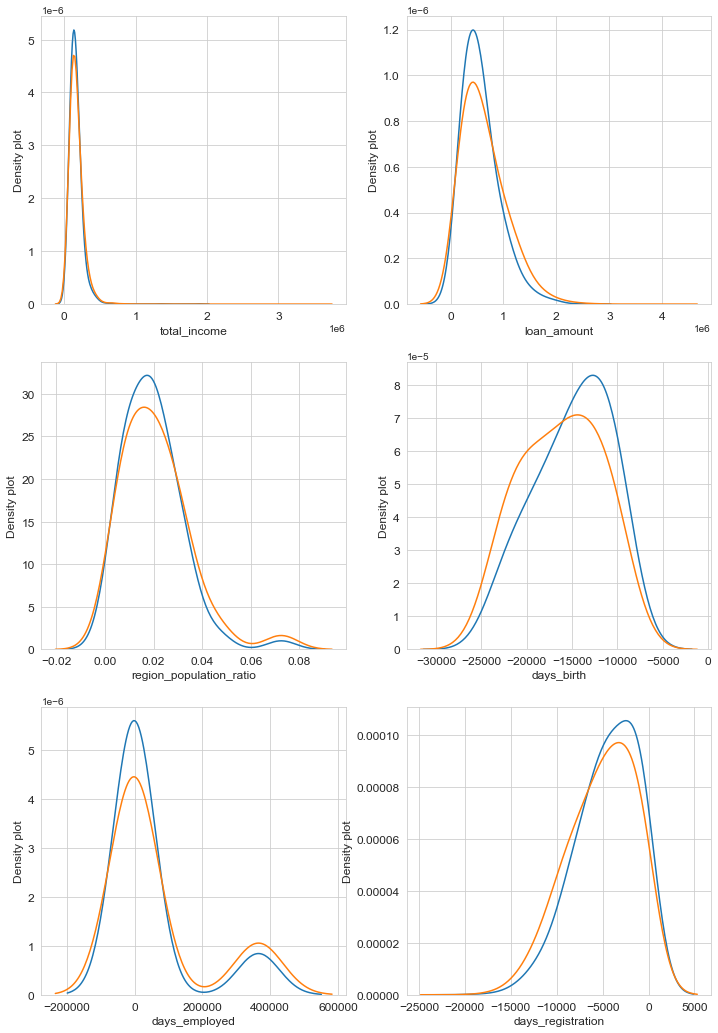

In [50]:
# Plotting a graph of variable distribution
var = ['total_income','loan_amount','region_population_ratio', 'days_birth','days_employed','days_registration']
plot_distribution_comp(var,nrow=3)

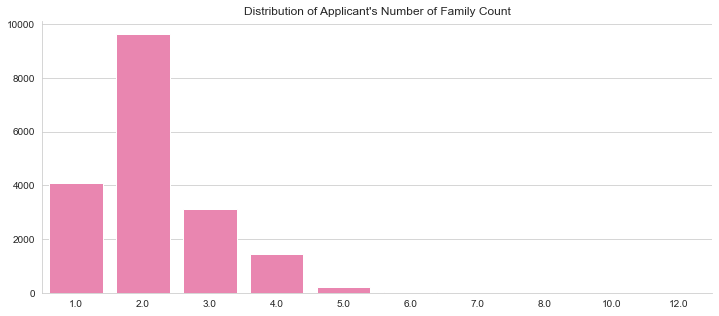

In [51]:
# Plotting a graph of variable distribution
t = accept["family_count"].value_counts()
t1 = pd.DataFrame()
t1['x'] = t.index 
t1['y'] = t.values 
plt.figure(figsize=(12,5));
plt.title("Distribution of Applicant's Number of Family Count");
ax = sns.barplot(data=t1, x="x", y="y", color="#f975ae");
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);

ax.set_ylabel('');    
ax.set_xlabel('');  

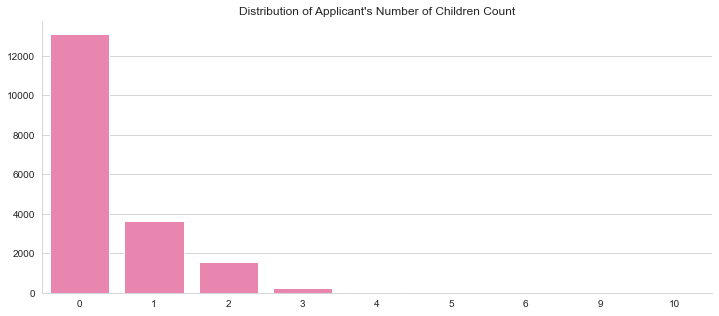

In [52]:
# Plotting a graph of variable distribution

t = accept["nr_children"].value_counts()
t1 = pd.DataFrame()
t1['x'] = t.index 
t1['y'] = t.values 
plt.figure(figsize=(12,5));
plt.title("Distribution of Applicant's Number of Children Count");
ax = sns.barplot(data=t1, x="x", y="y", color="#f975ae");
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);

ax.set_ylabel('');    
ax.set_xlabel('');          


<AxesSubplot:>

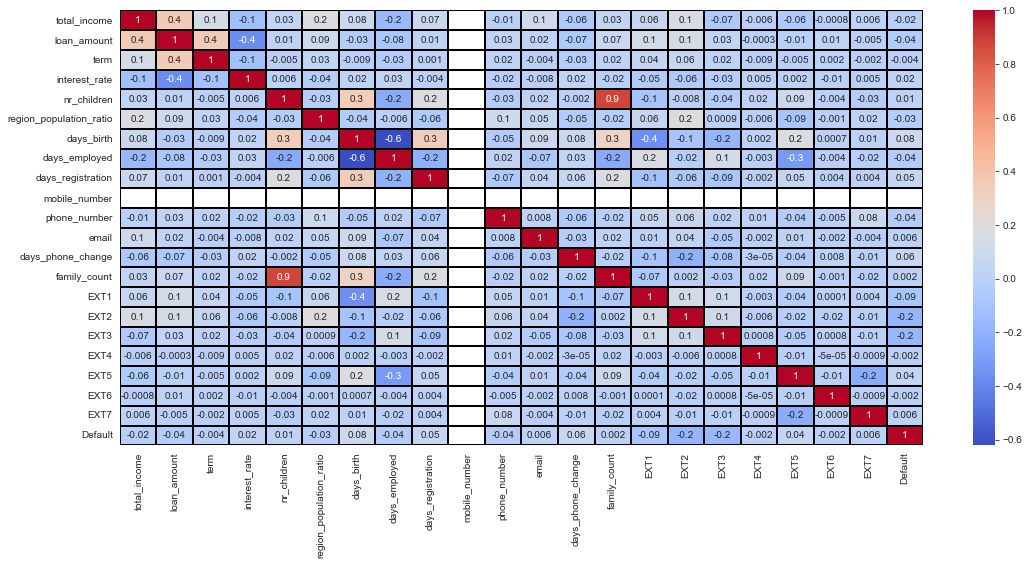

In [53]:
# Plotting a graph of variable distribution
plt.figure(figsize=(18,8))
cor=accept.corr()
sns.heatmap(cor,annot=True, cmap='coolwarm',fmt='.1g', linewidths=2, linecolor='black',)

In [54]:
# Dropping column not in use
#accept.drop(columns='mobile_number', inplace=True)
#reject.drop(columns='mobile_number', inplace=True)

## DSR (Debt Service Ratio)

In [55]:
# debt service ratio or DSR
accept['dsr'] = accept['loan_amount']/accept['total_income']

In [56]:
# debt service ratio or DSR
reject['dsr'] = reject['loan_amount']/reject['total_income']

In [57]:
# debt service ratio or DSR print
accept['dsr']
reject['dsr']

0        3.292000
1        6.249900
2        3.514800
3        6.666667
4       11.980000
          ...    
9107     4.792000
9108     3.072533
9109     4.073200
9110     4.102700
9111     1.083429
Name: dsr, Length: 9112, dtype: float64

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



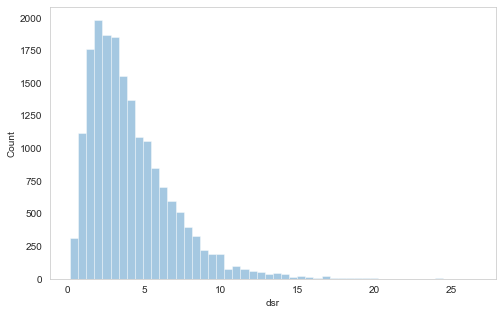

In [58]:
# Plottingt the distribution graph
plt.subplots(figsize=(8,5))
sns.distplot(accept['dsr'], kde=False)
plt.grid(False)
plt.ylabel('Count')
plt.show()

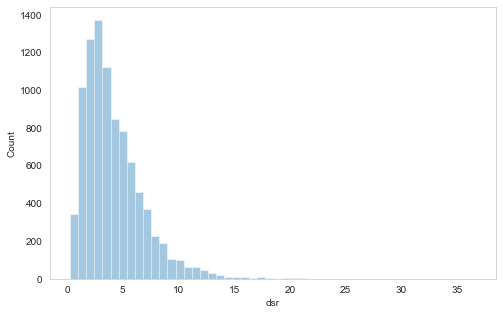

In [59]:
# Plottingt the distribution graph
plt.subplots(figsize=(8,5))
sns.distplot(reject['dsr'], kde=False)
plt.grid(False)
plt.ylabel('Count')
plt.show()

In [60]:
# Checking the dsr higher than 80 percent
accept.loc[accept['dsr']>0.8]

,total_income,loan_amount,term,interest_rate,own_car,own_house,nr_children,income_type,education_type,family_status,...,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,Default,dsr
0,157500.0,288562.5,30,3.737395,Y,N,0,Commercial associate,Secondary / secondary special,Married,...,2.0,0.505589,0.541308,0.236611,0,0,0,0,0,1.832143
1,76500.0,225000.0,48,3.654300,N,Y,3,Working,Secondary / secondary special,Separated,...,4.0,0.505589,0.395423,0.673830,0,1,0,0,0,2.941176
2,67500.0,409653.0,12,3.262865,Y,N,0,Working,Secondary / secondary special,Civil marriage,...,2.0,0.505589,0.649417,0.042929,0,1,0,0,1,6.068933
3,180000.0,328405.5,24,4.773736,Y,N,1,Working,Secondary / secondary special,Separated,...,2.0,0.512811,0.337838,0.852828,0,1,0,0,0,1.824475
4,130500.0,1225224.0,60,2.867961,N,N,0,Pensioner,Secondary / secondary special,Married,...,2.0,0.595440,0.537174,0.367291,0,0,0,0,0,9.388690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18544,90000.0,101880.0,30,3.433528,N,N,0,Working,Secondary / secondary special,Single / not married,...,1.0,0.337787,0.706669,0.531686,0,0,0,0,0,1.132000
18545,184500.0,1686591.0,60,2.372974,Y,Y,0,Commercial associate,Higher education,Married,...,2.0,0.505589,0.781010,0.616122,0,1,0,0,0,9.141415
18546,157500.0,203760.0,30,4.155449,N,N,0,State servant,Higher education,Married,...,2.0,0.291786,0.327604,0.382502,0,1,0,0,0,1.293714
18547,157500.0,348264.0,36,2.694917,Y,Y,1,Working,Secondary / secondary special,Married,...,3.0,0.431172,0.610530,0.730987,0,1,0,0,0,2.211200


In [61]:
# Checking the dsr higher than 80 percent
reject.loc[reject['dsr']>0.8]

,total_income,loan_amount,term,interest_rate,own_car,own_house,nr_children,income_type,education_type,family_status,...,occupation_type,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,dsr
0,270000.0,888840.0,48,2.344399,N,Y,1,Commercial associate,Higher education,Married,...,Core staff,3.0,0.480482,0.409056,0.687933,0,1,0,0,3.292000
1,90000.0,562491.0,36,3.195584,N,Y,0,Working,Secondary / secondary special,Married,...,Laborers,2.0,0.398079,0.693795,0.563835,0,1,0,0,6.249900
2,225000.0,790830.0,48,3.156887,Y,Y,0,Working,Secondary / secondary special,Single / not married,...,Laborers,1.0,0.023845,0.420569,0.692559,0,1,0,0,3.514800
3,135000.0,900000.0,42,3.472026,N,N,0,Commercial associate,Secondary / secondary special,Married,...,Sales staff,2.0,0.480482,0.108418,0.441836,0,0,0,1,6.666667
4,67500.0,808650.0,24,2.610668,N,N,0,Pensioner,Secondary / secondary special,Single / not married,...,Unidentified,1.0,0.480482,0.508502,0.771362,0,1,0,0,11.980000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9107,112500.0,539100.0,12,1.806103,N,N,0,Working,Secondary / secondary special,Single / not married,...,Sales staff,1.0,0.626007,0.304608,0.513694,0,1,0,0,4.792000
9108,67500.0,207396.0,24,3.864475,N,Y,0,Working,Incomplete higher,Single / not married,...,Sales staff,1.0,0.617507,0.101763,0.513694,0,1,0,0,3.072533
9109,157500.0,641529.0,48,3.262304,N,Y,0,Working,Higher education,Widow,...,Core staff,1.0,0.480482,0.667623,0.567379,0,1,0,0,4.073200
9110,180000.0,738486.0,60,3.728453,N,Y,0,Working,Secondary / secondary special,Married,...,Sales staff,2.0,0.581901,0.328250,0.722393,0,1,0,0,4.102700


In [62]:
# Binning
df_dsr = accept[['Default', 'dsr']]
df_dsr['bin_dsr'] = pd.qcut(df_dsr['dsr'].astype(float), q=5, duplicates='drop', precision=0) # dsr 5 (Binning)
df_dsr = df_dsr.groupby('bin_dsr').agg({'Default': ['count', 'sum']}) # sum = bad = 1
df_dsr.columns = df_dsr.columns.map('_'.join)
df_dsr['dist'] = df_dsr['Default_count']/df_dsr['Default_count'].sum() # Sum all = 1 # distribution mean
df_dsr['bad_rate'] = df_dsr['Default_sum']/df_dsr['Default_count'] # bad_rate 
df_dsr = df_dsr.reset_index()
df_dsr

C:\Users\eomuvwie\AppData\Local\Temp/ipykernel_24268/94896506.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,bin_dsr,Default_count,Default_sum,dist,bad_rate
0,"(-1.0, 2.0]",3710,301,0.200011,0.081132
1,"(2.0, 3.0]",3710,359,0.200011,0.096765
2,"(3.0, 4.0]",3709,353,0.199957,0.095174
3,"(4.0, 6.0]",3797,319,0.204701,0.084014
4,"(6.0, 27.0]",3623,253,0.195321,0.069832


C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



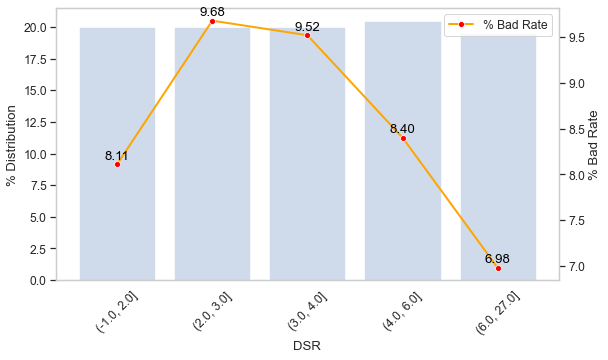

In [63]:
# Plottingt the distribution graph
x1 = df_dsr['bin_dsr'].astype(str)
x2 = df_dsr.index
y1 = df_dsr['dist']*100
y2 = df_dsr['bad_rate']*100

sns.set(font_scale=1.1)
sns.set_style("whitegrid")
fig, ax1  = plt.subplots(figsize=(9,5))
plt.tick_params(axis='x', rotation = 45)

ax1.bar(x1,y1, data = df_dsr, color='lightsteelblue', alpha=.6)
ax1.xaxis.grid()
ax2 = ax1.twinx()
ax2 = sns.lineplot(x2, y2, data = df_dsr, marker='o',\
                markerfacecolor='red', markersize=6, color='orange', 
                linewidth=2, label='% Bad Rate')
ax1.set_xlabel('DSR')
ax1.set_ylabel('% Distribution')
ax2.set_ylabel('% Bad Rate')
ax1.grid(False)
ax2.grid(False)

for x,y in zip(x2,y2):
        label = "{:.2f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,5), ha='center', color='black') 


plt.show()

## Splitting the dataset into Test and Train sets

In [64]:
# Defining X (predictive variables) and y (dependent variable)
X=accept.drop(['Default'], axis=1)
y=accept[["Default"]].reset_index(drop=True)

In [65]:
# drop missing values
accept = accept.dropna().reset_index(drop=True)
reject = reject.dropna().reset_index(drop=True)

In [66]:
# Splitting into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123, stratify=y)

In [67]:
# Splitting into valid and test datasets
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=.5, random_state=234, stratify=y_test)

## Weight of Evidence (WOE) & Information Value (IV)

In [68]:
# These functions allow us to group the different variables in some bins and also we can calculate the WOE for each group
# and the IV for each variable

# reference: https://github.com/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [69]:
# Applying the WOE and IV in the training dataset
final_iv, IV = data_vars(X_train, y_train.Default)

C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



In [70]:
# Print the results
IV.sort_values('IV')

,VAR_NAME,IV
20,mobile_number,0.000000e+00
3,EXT4,0.000000e+00
5,EXT6,9.653759e-09
14,family_count,4.204407e-04
18,interest_rate,1.277854e-03
23,own_car,1.650891e-03
6,EXT7,2.201252e-03
28,total_income,2.226140e-03
21,nr_children,2.310457e-03
13,email,2.911559e-03


In [71]:
# Function to group variables by IV values
def iv_group(df):
  
    if df['IV'] > 0.5:
        val = 'Suspicious'
    elif df['IV'] > 0.3 and df['IV'] <= 0.5 :
        val = 'Strong'
    elif df['IV'] > 0.1 and df['IV'] <= 0.3 :
        val = 'Medium'
    elif df['IV'] > 0.02 and df['IV'] <= 0.1 :
        val = 'Weak'
    else:
        val = 'Not useful'

    return val

IV['Predictive_Power'] = IV.apply(iv_group, axis=1)
IV['Predictive_Power']= IV['Predictive_Power'][:10]
IV.sort_values('IV',ascending=False)

,VAR_NAME,IV,Predictive_Power
2,EXT3,4.142401e-01,Strong
1,EXT2,4.141923e-01,Strong
22,occupation_type,1.100247e-01,NaN
0,EXT1,1.024957e-01,Medium
7,days_birth,9.755936e-02,Weak
17,income_type,5.969317e-02,NaN
9,days_phone_change,4.728929e-02,Weak
16,housing_type,4.677520e-02,NaN
12,education_type,3.915292e-02,NaN
15,family_status,3.481044e-02,NaN


In [72]:
# Printing results
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,total_income,27000.0,157500.0,6493,575,0.088557,5918,0.911443,0.604627,0.581450,0.039086,2.226140e-03
1,total_income,157950.0,3600000.0,4636,376,0.081104,4260,0.918896,0.395373,0.418550,-0.056966,2.226140e-03
2,loan_amount,45000.0,539100.0,5580,542,0.097133,5038,0.902867,0.569926,0.494989,0.140971,2.260067e-02
3,loan_amount,539230.5,4050000.0,5549,409,0.073707,5140,0.926293,0.430074,0.505011,-0.160623,2.260067e-02
4,term,12.0,24.0,4750,431,0.090737,4319,0.909263,0.453207,0.424347,0.065799,3.810426e-03
...,...,...,...,...,...,...,...,...,...,...,...,...
108,EXT6,1,1,1,0,0.000000,1,1.000000,0.000000,0.000098,0.000000,9.653759e-09
109,EXT7,0,0,10968,932,0.084974,10036,0.915026,0.980021,0.986048,-0.006131,2.201252e-03
110,EXT7,1,1,161,19,0.118012,142,0.881988,0.019979,0.013952,0.359082,2.201252e-03
111,dsr,0.18395,3.472222,5565,525,0.094340,5040,0.905660,0.552050,0.495186,0.108707,1.297749e-02


In [73]:
# Applying the WOE in the X_train, X_valid and X_test datasets
transform_vars_list = X_train.columns.difference(['Default'])
transform_prefix = 'new_'

In [74]:
# Print variable
transform_vars_list

Index(['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'days_birth',
       'days_employed', 'days_phone_change', 'days_registration', 'dsr',
       'education_type', 'email', 'family_count', 'family_status',
       'housing_type', 'income_type', 'interest_rate', 'loan_amount',
       'mobile_number', 'nr_children', 'occupation_type', 'own_car',
       'own_house', 'phone_number', 'region_population_ratio', 'term',
       'total_income'],
      dtype='object')

In [75]:
# reference: https://github.com/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb 
# Function to transform names of values
def transf(df):
    for var in transform_vars_list:
        small_df = final_iv[final_iv['VAR_NAME'] == var]
        transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
        replace_cmd = ''
        replace_cmd1 = ''
        for i in sorted(transform_dict.items()):
            replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
            replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
        replace_cmd = replace_cmd + '0'
        replace_cmd1 = replace_cmd1 + '0'
        if replace_cmd != '0':
            try:
                df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd))
            except:
                df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd1))
            
    return df

In [76]:
# Applying function
X_train_woe = transf(X_train)
X_train_woe

,total_income,loan_amount,term,interest_rate,own_car,own_house,nr_children,income_type,education_type,family_status,...,new_loan_amount,new_mobile_number,new_nr_children,new_occupation_type,new_own_car,new_own_house,new_phone_number,new_region_population_ratio,new_term,new_total_income
9738,67500.0,101880.0,18,3.172373,Y,Y,1,State servant,Secondary / secondary special,Separated,...,0.140971,0.0,-0.016105,0.277724,-0.057184,-0.068450,0.096616,0.059747,0.065799,0.039086
15328,225000.0,592560.0,42,4.155246,N,Y,0,Working,Higher education,Married,...,-0.160623,0.0,-0.016105,0.280998,0.028874,-0.068450,0.096616,-0.065990,-0.029139,-0.056966
14830,202500.0,900000.0,54,2.589358,N,N,3,Working,Higher education,Married,...,-0.160623,0.0,0.143487,0.472227,0.028874,0.135517,0.096616,0.059747,-0.085559,-0.056966
12186,193500.0,463500.0,24,2.074020,Y,N,0,Working,Secondary / secondary special,Widow,...,0.140971,0.0,-0.016105,-0.381432,-0.057184,0.135517,0.096616,-0.065990,0.065799,-0.056966
9727,90000.0,139230.0,12,3.127348,N,Y,2,State servant,Secondary / secondary special,Married,...,0.140971,0.0,0.143487,-0.381432,0.028874,-0.068450,0.096616,0.059747,0.065799,0.039086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16288,135000.0,273636.0,30,3.279429,N,Y,0,Working,Higher education,Single / not married,...,0.140971,0.0,-0.016105,0.123926,0.028874,-0.068450,0.096616,-0.065990,-0.029139,0.039086
5651,180000.0,258709.5,30,3.986534,Y,Y,1,Working,Secondary / secondary special,Married,...,0.140971,0.0,-0.016105,0.472227,-0.057184,-0.068450,0.096616,0.059747,-0.029139,-0.056966
4805,90000.0,1056447.0,36,3.256524,N,Y,0,State servant,Secondary / secondary special,Married,...,-0.160623,0.0,-0.016105,0.123926,0.028874,-0.068450,0.096616,-0.065990,-0.029139,0.039086
14434,315000.0,473760.0,12,3.873846,Y,Y,0,Commercial associate,Higher education,Single / not married,...,0.140971,0.0,-0.016105,-0.134300,-0.057184,-0.068450,0.096616,0.059747,0.065799,-0.056966


In [77]:
# Applying function
X_valid_woe=transf(X_valid)
X_test_woe=transf(X_test)

In [78]:
# Keeping only the variables with the WOE value
X_train_woe=X_train_woe.loc[:, X_train_woe.columns.str.contains('new')]
X_valid_woe=X_valid_woe.loc[:, X_valid_woe.columns.str.contains('new')]
X_test_woe=X_test_woe.loc[:, X_test_woe.columns.str.contains('new')]   

In [79]:
# Print the results
X_train_woe

,new_EXT1,new_EXT2,new_EXT3,new_EXT4,new_EXT5,new_EXT6,new_EXT7,new_days_birth,new_days_employed,new_days_phone_change,...,new_loan_amount,new_mobile_number,new_nr_children,new_occupation_type,new_own_car,new_own_house,new_phone_number,new_region_population_ratio,new_term,new_total_income
9738,0.143543,0.487872,0.081255,0.0,-0.328388,0.000098,-0.006131,-0.022629,-0.138023,0.035391,...,0.140971,0.0,-0.016105,0.277724,-0.057184,-0.068450,0.096616,0.059747,0.065799,0.039086
15328,0.143543,1.020107,-0.818329,0.0,0.077454,0.000098,-0.006131,-0.022629,-0.138023,0.035391,...,-0.160623,0.0,-0.016105,0.280998,0.028874,-0.068450,0.096616,-0.065990,-0.029139,-0.056966
14830,0.143543,1.020107,0.181951,0.0,0.077454,0.000098,-0.006131,0.123342,-0.138023,0.035391,...,-0.160623,0.0,0.143487,0.472227,0.028874,0.135517,0.096616,0.059747,-0.085559,-0.056966
12186,-0.720148,-0.640661,0.081255,0.0,0.077454,0.000098,-0.006131,-0.340942,0.123938,-0.315395,...,0.140971,0.0,-0.016105,-0.381432,-0.057184,0.135517,0.096616,-0.065990,0.065799,-0.056966
9727,0.143543,-0.327271,0.081255,0.0,0.077454,0.000098,-0.006131,0.448777,0.123938,-0.315395,...,0.140971,0.0,0.143487,-0.381432,0.028874,-0.068450,0.096616,0.059747,0.065799,0.039086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16288,0.143543,-0.640661,0.181951,0.0,-0.328388,0.000098,-0.006131,0.448777,0.123938,0.220271,...,0.140971,0.0,-0.016105,0.123926,0.028874,-0.068450,0.096616,-0.065990,-0.029139,0.039086
5651,0.143543,-0.150902,-0.052195,0.0,-0.328388,0.000098,-0.006131,-0.023316,0.123938,0.220271,...,0.140971,0.0,-0.016105,0.472227,-0.057184,-0.068450,0.096616,0.059747,-0.029139,-0.056966
4805,0.143543,-0.048798,0.181951,0.0,0.077454,0.000098,-0.006131,-0.023316,-0.138023,0.035391,...,-0.160623,0.0,-0.016105,0.123926,0.028874,-0.068450,0.096616,-0.065990,-0.029139,0.039086
14434,0.143543,-1.552328,0.081255,0.0,-0.328388,0.000098,-0.006131,0.123342,0.123938,-0.315395,...,0.140971,0.0,-0.016105,-0.134300,-0.057184,-0.068450,0.096616,0.059747,0.065799,-0.056966


## Modeling

In [80]:
"""Preparing Side to Side Comparative Function"""
from sklearn.preprocessing import MinMaxScaler


def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 2), ranks)
    return dict(zip(names, ranks))


names = X.columns
ranks = {}
print('Prep done...')

Prep done...


In [81]:
"""
LASSO via LogisticRegression l1 penalty - Feature Importance - PART 1
"""
print('Running LASSO via LogisticRegression l1 penalty...')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

""""Transform data for LogRef fitting"""
scaler = StandardScaler()
std_data = pd.DataFrame(scaler.fit_transform(X_train_woe.values))

"""Establish Model"""
model_LogRegLASSO = LogisticRegression(penalty='l1', C=0.1, random_state=42, solver='liblinear', n_jobs=1)
model_LogRegLASSO.fit(std_data, np.ravel(y_train))

"""For Side To Side"""
ranks["LogRegLASSO"] = rank_to_dict(list(map(float, model_LogRegLASSO.coef_.reshape(len(names), -1))), names, order=1)
print(ranks["LogRegLASSO"])

Running LASSO via LogisticRegression l1 penalty...
{'total_income': 0.36, 'loan_amount': 0.95, 'term': 1.0, 'interest_rate': 0.02, 'own_car': 0.2, 'own_house': 0.03, 'nr_children': 0.09, 'income_type': 0.04, 'education_type': 0.17, 'family_status': 0.05, 'housing_type': 0.16, 'region_population_ratio': 0.06, 'days_birth': 0.18, 'days_employed': 0.14, 'days_registration': 0.0, 'mobile_number': 0.12, 'phone_number': 0.18, 'email': 0.09, 'days_phone_change': 0.02, 'occupation_type': 0.02, 'family_count': 0.02, 'EXT1': 0.04, 'EXT2': 0.39, 'EXT3': 0.1, 'EXT4': 0.05, 'EXT5': 0.19, 'EXT6': 0.0, 'EXT7': 0.02, 'dsr': 0.01}


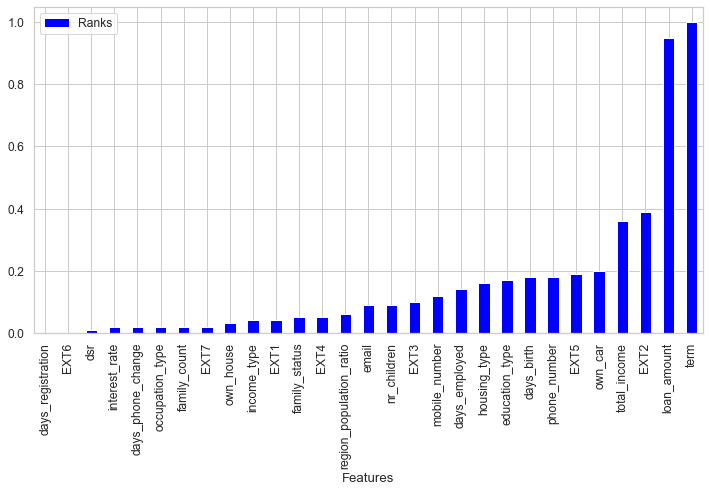

In [82]:
# Plot Feature Ranking
"""Plotting"""
import operator
listsLASSO = sorted(ranks["LogRegLASSO"].items(), key=operator.itemgetter(1))
# convert list>array>dataframe
dfLASSO = pd.DataFrame(np.array(listsLASSO).reshape(len(listsLASSO), 2),
                       columns=['Features', 'Ranks']).sort_values('Ranks')
dfLASSO['Ranks'] = dfLASSO['Ranks'].astype(float)

dfLASSO.plot.bar(x='Features', y='Ranks', color='blue')
plt.xticks(rotation=90)
plt.show()

## Logistic Regression Model

In [83]:
# evaluation metrics
def eval_metrics(proba, true):
    proba   = np.asarray(proba)
    true  = np.asarray(true, dtype=int)
    pred    = np.round(proba) # convert proba to binary labels

    auc         = roc_auc_score(true, proba)
    f1          = f1_score(true, pred)

    return {
        'AUC': auc,
        'F1': f1,
    }

In [84]:
def run_GridSearch(name, data, model, param_grid, **kwargs):
    # save results
    metrics = kwargs.get("metrics", defaultdict(dict))

    #grid search parameters in grid_values
    #scoring is based on roc_auc -> outcome of gs is best model from grid search
    gs = GridSearchCV(model, param_grid = param_grid, scoring = kwargs.get("scoring", 'roc_auc'), cv=kwargs.get("cv", 3), refit=kwargs.get("refit", True))
    gs.fit(X_train_woe, y_train)
    
    # predict
    proba_train   = pd.DataFrame(gs.predict_proba(X_train_woe))[1]
    proba_valid   = pd.DataFrame(gs.predict_proba(X_valid_woe))[1]

    # evaluate
    metrics[name]["train"] = eval_metrics(proba_train,data["y_train"])
    metrics[name]["valid"] = eval_metrics(proba_valid,data["y_valid"])

    # prints
    if kwargs.get("print", True):
        print(f"{name}: {gs.best_params_}")
        for key, val in metrics[name].items():
            print(f"{key}: ", "\t".join([f"{k}: {v:.4f}" for k,v in val.items()]))

        cmtx = pd.DataFrame(
        confusion_matrix(np.array(y_valid), np.round(proba_valid)), 
        index=['true:no', 'true:yes'], 
        columns=['pred:no', 'pred:yes'])

        print(cmtx)
    
    return gs, metrics

In [85]:
data_temp = {
    "X_train":X_train_woe,
    "y_train":y_train,
    "X_valid":X_valid_woe,
    "y_valid":y_valid,
}

In [86]:
#Setup Grid search for logistic regression model
#You can add more models to it 
logistic = LogisticRegression()

models = {"logistic":logistic}

# grid search values 
grid_values = {
                "logistic":{
                    "solver":["liblinear"],
                    'penalty': ['l1', 'l2'],
                    'C':[0.25, 0.5, 1, 3], 
                    "max_iter":[200,300],
                    "class_weight": ["balanced"]
                }
            }

In [87]:
model_dict = defaultdict(dict)
metric_dict = defaultdict(dict)

#loop through models in models dictionary
for name, model in models.items():
    model_dict[name], metric_dict = run_GridSearch(name=name, data=data_temp, model=model, param_grid=grid_values[name], metrics=metric_dict)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\uti

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\uti

logistic: {'C': 0.25, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
train:  AUC: 0.7618	F1: 0.2713
valid:  AUC: 0.7109	F1: 0.2452
          pred:no  pred:yes
true:no      2257      1136
true:yes      114       203


In [88]:
#add model metrics to result dataframe
overview = pd.DataFrame(model_dict["logistic"].cv_results_)
overview.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.030337,0.001714,0.007025,0.000038,0.25,balanced,200,l1,liblinear,"{'C': 0.25, 'class_weight': 'balanced', 'max_i...",0.740938,0.763400,0.763887,0.756075,0.010705,4
1,0.058391,0.006803,0.005333,0.001248,0.25,balanced,200,l2,liblinear,"{'C': 0.25, 'class_weight': 'balanced', 'max_i...",0.740837,0.762939,0.764569,0.756115,0.010824,1


In [89]:
import plotly.express as px
# Refit selected model
model1 = LogisticRegression(**model_dict["logistic"].best_params_)
model1.fit(X_train_woe, np.ravel(y_train))

# Display Model Coefficients
log_coef = pd.DataFrame(model1.coef_, index=['beta'], columns=X_train_woe.columns).T\
.sort_values('beta', ascending=False).reset_index()

log_coef['round_beta'] = round(log_coef['beta'], 2)

"""For Side To Side"""
ranks["model1"] = rank_to_dict(list(map(float, model1.coef_.reshape(len(names), -1))), names, order=1)
print(ranks["model1"])

{'total_income': 0.74, 'loan_amount': 0.9, 'term': 0.93, 'interest_rate': 0.34, 'own_car': 0.73, 'own_house': 0.34, 'nr_children': 0.6, 'income_type': 0.36, 'education_type': 0.9, 'family_status': 0.4, 'housing_type': 0.62, 'region_population_ratio': 0.42, 'days_birth': 0.68, 'days_employed': 1.0, 'days_registration': 0.22, 'mobile_number': 0.59, 'phone_number': 0.7, 'email': 0.52, 'days_phone_change': 0.34, 'occupation_type': 0.29, 'family_count': 0.34, 'EXT1': 0.59, 'EXT2': 0.84, 'EXT3': 0.87, 'EXT4': 0.55, 'EXT5': 0.74, 'EXT6': 0.0, 'EXT7': 0.4, 'dsr': 0.08}


In [90]:
#plotting the graph
fig = px.bar(log_coef, y='index', x='beta', text='round_beta', orientation='h')
fig.update_traces(textposition='outside', marker_color='rgb(0, 92, 153)')
fig.update_layout(title='Logistic Regression Coefficients',
                  dragmode='select',
                  width=1000,
                  height=800,
                  hovermode='closest')

fig.show()

In [91]:
C = pd.DataFrame(X_valid['interest_rate']).merge(accept[['interest_rate','Default']], on='interest_rate', how='right')
C.head(2)

,interest_rate,Default
0,3.737395,0
1,3.654300,0


In [92]:
# Making predictions in the valid dataset
prob_lr = model1.predict_proba(X_valid_woe)
preds_lr = pd.DataFrame(prob_lr[:,1], columns = ['prob_default'])
preds_lr['default_status'] = preds_lr['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)
preds_lr['actual'] = C['Default']

In [93]:
preds_lr

,prob_default,default_status,actual
0,0.189783,0,0
1,0.794936,1,0
2,0.381448,0,1
3,0.598329,1,0
4,0.478342,0,0
...,...,...,...
3705,0.109426,0,0
3706,0.067188,0,0
3707,0.363263,0,0
3708,0.172921,0,0


'AUC_valid= 0.7109236775287031.'

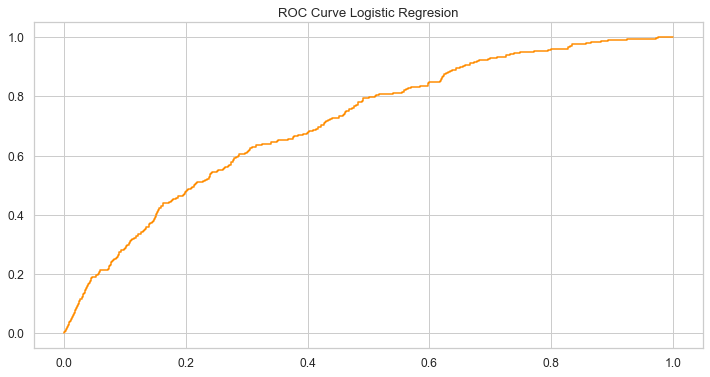

In [94]:
fallout, sensitivity, thresholds = roc_curve(y_valid, preds_lr['prob_default'])
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.title('ROC Curve Logistic Regresion')

# Calculating the AUC in the valid dataset
auc_lr=roc_auc_score(y_valid,preds_lr['prob_default'])
f'AUC_valid= {auc_lr}.'

In [95]:
# Create metrics evaluation report
target_names=['non_default','default']
print(classification_report(y_valid, preds_lr['default_status'], target_names=target_names))

              precision    recall  f1-score   support

 non_default       0.95      0.67      0.78      3393
     default       0.15      0.64      0.25       317

    accuracy                           0.66      3710
   macro avg       0.55      0.65      0.51      3710
weighted avg       0.88      0.66      0.74      3710



## Random Forest model

In [96]:
from sklearn.ensemble import RandomForestClassifier
# Defining random forest model
rfc=RandomForestClassifier()

# Create param grid
rfcParams = {'n_estimators': [150,300,500],'max_features': ['auto', 'sqrt'],'max_depth' : [3,6,9]}

# Create grid search object
cv_rfc = GridSearchCV(rfc,rfcParams, cv=3)

# Fit model 
best_rf = cv_rfc.fit(X_train_woe, np.ravel(y_train))

In [97]:
# Best Parameters for the Random Forest
best_rf.best_estimator_

RandomForestClassifier(max_depth=3, n_estimators=150)

In [98]:
"""
Random Forest Classifier - Feature Importance - PART 1
"""

model_RFC = RandomForestClassifier(bootstrap=True, max_depth=80,
                                   criterion='entropy',
                                   min_samples_leaf=3, min_samples_split=10, n_estimators=100)
model_RFC.fit(X_train_woe, y_train)
#model_RFC.fit(std_data, y_train)
print("Random Forest Classifier Fitted")

"""Side To Side"""
print("Ranking Features with RFClassifier...")
ranks["RFC"] = rank_to_dict(model_RFC.feature_importances_, names)
print(ranks["RFC"])

C:\Users\eomuvwie\AppData\Local\Temp/ipykernel_24268/2110649308.py:8: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Random Forest Classifier Fitted
Ranking Features with RFClassifier...
{'total_income': 0.17, 'loan_amount': 1.0, 'term': 0.95, 'interest_rate': 0.0, 'own_car': 0.13, 'own_house': 0.0, 'nr_children': 0.02, 'income_type': 0.52, 'education_type': 0.16, 'family_status': 0.3, 'housing_type': 0.38, 'region_population_ratio': 0.16, 'days_birth': 0.19, 'days_employed': 0.06, 'days_registration': 0.13, 'mobile_number': 0.32, 'phone_number': 0.54, 'email': 0.24, 'days_phone_change': 0.19, 'occupation_type': 0.17, 'family_count': 0.0, 'EXT1': 0.08, 'EXT2': 0.62, 'EXT3': 0.16, 'EXT4': 0.17, 'EXT5': 0.15, 'EXT6': 0.18, 'EXT7': 0.29, 'dsr': 0.17}


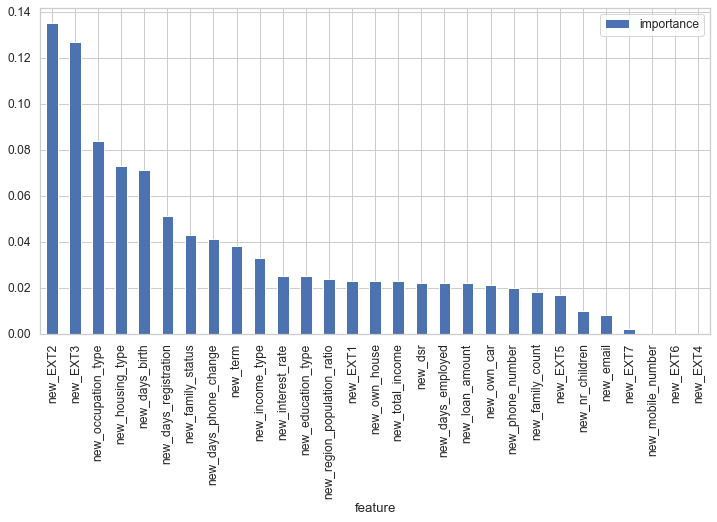

In [99]:
"""Plotting"""
# For Chart
importance = pd.DataFrame({'feature': X_train_woe.columns, 'importance': np.round(model_RFC.feature_importances_, 3)})
importance_sorted = importance.sort_values('importance', ascending=False).set_index('feature')
# plot feature importance for feature selection using default inbuild function
#print(importance_sorted)
importance_sorted.plot.bar()
plt.show()

In [100]:
# Making predictions in the valid dataset
prob_rf = best_rf.predict_proba(X_valid_woe)
preds_rf = pd.DataFrame(prob_rf[:,1], columns = ['prob_default'])
preds_rf['default_status'] = preds_rf['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

'AUC_valid= 0.6857028898799812.'

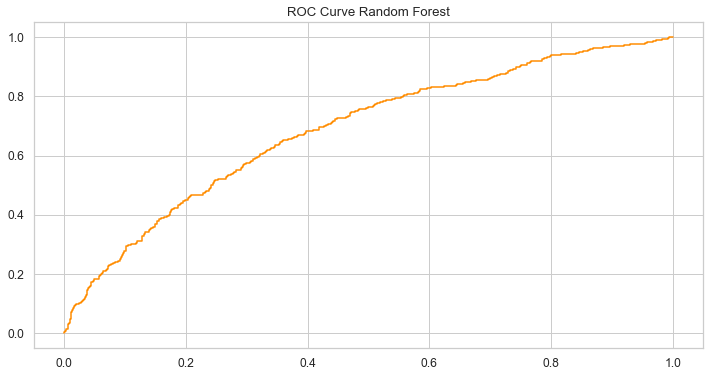

In [101]:
fallout, sensitivity, thresholds = roc_curve(y_valid, preds_rf['prob_default'])
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.title('ROC Curve Random Forest')

# Calculating the AUC in the valid dataset
auc_rf=roc_auc_score(y_valid,preds_rf['prob_default'])
f'AUC_valid= {auc_rf}.'

In [102]:
# Create metrics evaluation report
target_names=['non_default','default']
print(classification_report(y_valid, preds_rf['default_status'], target_names=target_names))

              precision    recall  f1-score   support

 non_default       0.91      1.00      0.96      3393
     default       0.00      0.00      0.00       317

    accuracy                           0.91      3710
   macro avg       0.46      0.50      0.48      3710
weighted avg       0.84      0.91      0.87      3710



C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



## LGB Model

In [103]:
## LGB Model for Feature Selection
lgb_train = lgb.Dataset(data=X_train_woe, label=np.ravel(y_train))
lgb_eval = lgb.Dataset(data=X_valid_woe, label=y_valid)
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
LGB = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

C:\tools\Anaconda3\envs\py\lib\site-packages\lightgbm\engine.py:177: UserWarning:

Found `num_iteration` in params. Will use it instead of argument

C:\tools\Anaconda3\envs\py\lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

C:\tools\Anaconda3\envs\py\lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.704145
Early stopping, best iteration is:
[169]	valid_0's auc: 0.705415


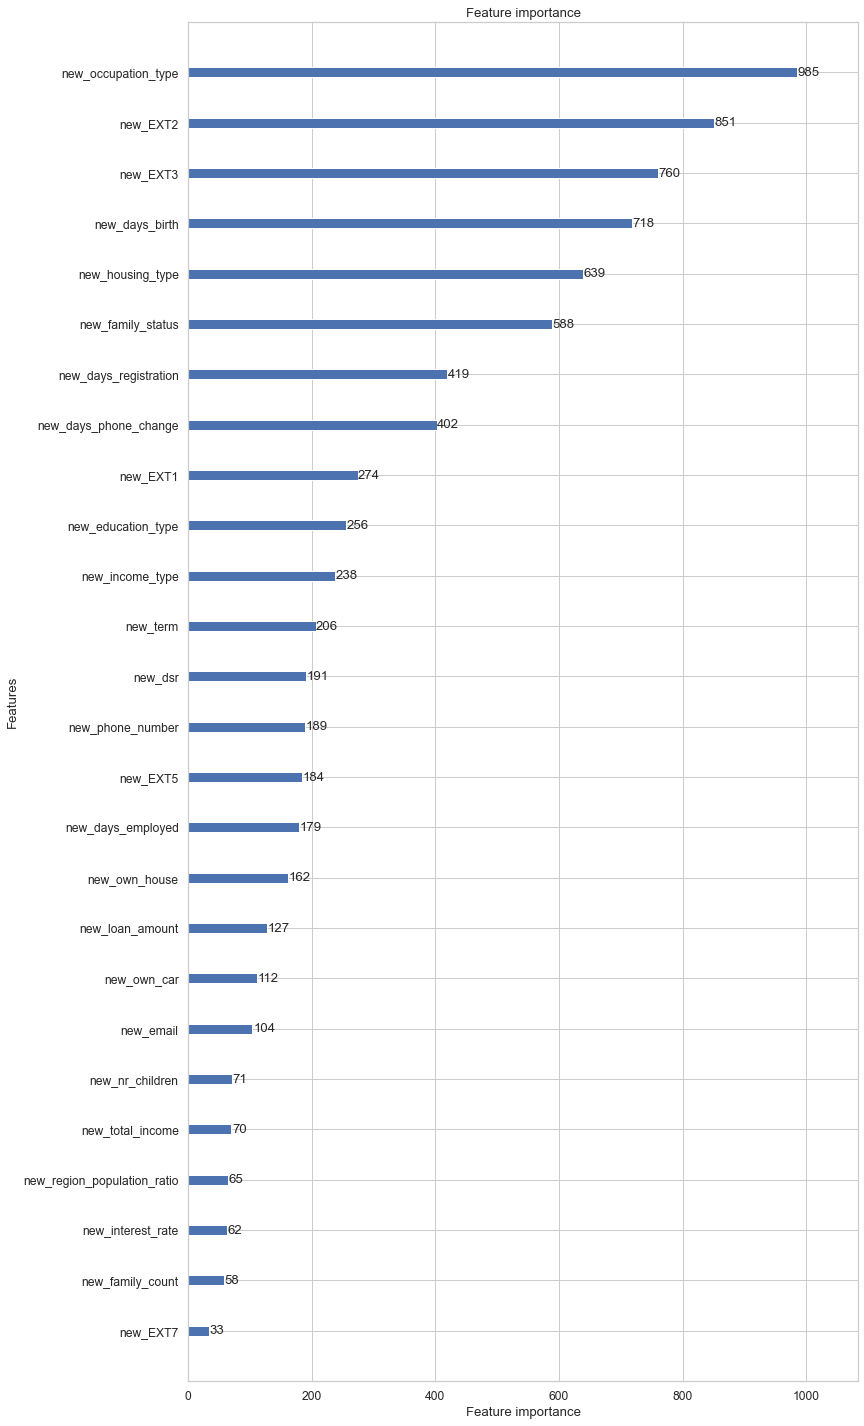

In [104]:
#Plotting the Feature Importance
lgb.plot_importance(LGB, figsize=(12, 25), max_num_features=100);

In [105]:
# Applying the model function
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train_woe,np.ravel(y_train),eval_set=[(X_test_woe,np.ravel(y_test)),(X_train_woe,np.ravel(y_train))],
          verbose=20,eval_metric='logloss')

C:\tools\Anaconda3\envs\py\lib\site-packages\lightgbm\sklearn.py:736: UserWarning:

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[20]	valid_0's binary_logloss: 0.26177	valid_1's binary_logloss: 0.236224
[40]	valid_0's binary_logloss: 0.26154	valid_1's binary_logloss: 0.215726
[60]	valid_0's binary_logloss: 0.263159	valid_1's binary_logloss: 0.199303
[80]	valid_0's binary_logloss: 0.265793	valid_1's binary_logloss: 0.185184
[100]	valid_0's binary_logloss: 0.268059	valid_1's binary_logloss: 0.173713


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=42)

In [106]:
# Printing the model AUC
print('Training accuracy {:.4f}'.format(model.score(X_train_woe,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test_woe,y_test)))

Training accuracy 0.9244
Testing accuracy 0.9140


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

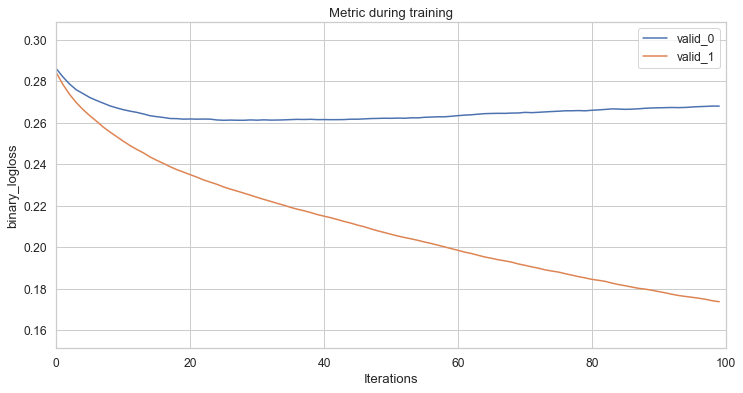

In [107]:
# Plot the metrics graph
lgb.plot_metric(model)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



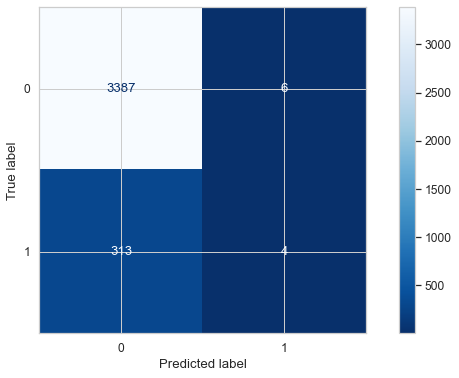

In [108]:
metrics.plot_confusion_matrix(model,X_test_woe,y_test,cmap='Blues_r')

In [109]:
# Printing out the eval_metrics
print(metrics.classification_report(y_test,model.predict(X_test_woe)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      3393
           1       0.40      0.01      0.02       317

    accuracy                           0.91      3710
   macro avg       0.66      0.51      0.49      3710
weighted avg       0.87      0.91      0.88      3710



## Gradient Boosting Model

In [110]:
# Defining Gradient Boosting model
gb = GradientBoostingClassifier()

# Create param grid
gbParam = {'learning_rate': [0.001,0.01, 0.05, 0.1],'max_features': ['auto', 'sqrt'],'max_depth' : [3,6,9]}

# Create grid search object
cv_gb = GridSearchCV(gb,gbParam, cv=3)

# Fit model 
best_gb = cv_gb.fit(X_train_woe, np.ravel(y_train))

In [111]:
# Best Parameters for the Gradient Boosting
best_gb.best_estimator_

GradientBoostingClassifier(learning_rate=0.001, max_features='auto')

In [112]:
# Making predictions in the valid dataset
prob_gb = best_gb.predict_proba(X_valid_woe)
preds_gb = pd.DataFrame(prob_gb[:,1], columns = ['prob_default'])
preds_gb['default_status'] = preds_gb['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

'AUC_valid= 0.6710368628676037.'

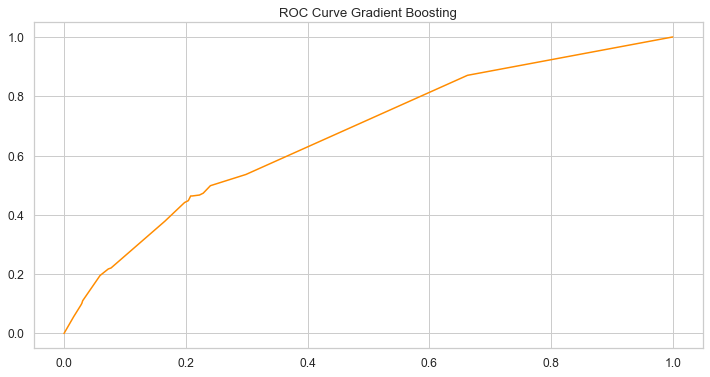

In [113]:
fallout, sensitivity, thresholds = roc_curve(y_valid, preds_gb['prob_default'])
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.title('ROC Curve Gradient Boosting')

# Calculating the AUC in the valid dataset
auc_gb=roc_auc_score(y_valid,preds_gb['prob_default'])
f'AUC_valid= {auc_gb}.'

# Other Models

## Ridge Model

In [114]:
"""
Ridge via LogisticRegression l2 penalty - Feature Importance - PART 1
"""

print('Running Ridge via LogisticRegression l2 penalty...')
"""Establish Model"""
model_LogRegRidge = LogisticRegression(penalty='l2', C=0.1, random_state=42, solver='liblinear', n_jobs=1)
model_LogRegRidge.fit(std_data, y_train)

"""For Side To Side"""
ranks["LogRegRidge"] = rank_to_dict(list(map(float, model_LogRegRidge.coef_.reshape(len(names), -1))),
                                    names, order=1)
print(ranks["LogRegRidge"])

Running Ridge via LogisticRegression l2 penalty...
{'total_income': 0.41, 'loan_amount': 0.95, 'term': 1.0, 'interest_rate': 0.07, 'own_car': 0.27, 'own_house': 0.13, 'nr_children': 0.15, 'income_type': 0.08, 'education_type': 0.23, 'family_status': 0.11, 'housing_type': 0.21, 'region_population_ratio': 0.11, 'days_birth': 0.24, 'days_employed': 0.19, 'days_registration': 0.0, 'mobile_number': 0.16, 'phone_number': 0.23, 'email': 0.15, 'days_phone_change': 0.05, 'occupation_type': 0.08, 'family_count': 0.07, 'EXT1': 0.13, 'EXT2': 0.42, 'EXT3': 0.17, 'EXT4': 0.11, 'EXT5': 0.25, 'EXT6': 0.02, 'EXT7': 0.08, 'dsr': 0.02}


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



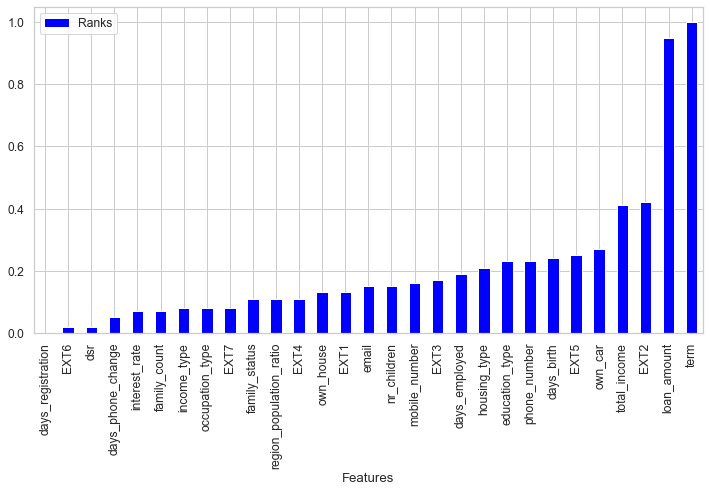

In [115]:
"""Plotting"""
import operator
listsRidge = sorted(ranks["LogRegRidge"].items(), key=operator.itemgetter(1))
dfRidge = pd.DataFrame(np.array(listsRidge).reshape(len(listsRidge), 2),
                       columns=['Features', 'Ranks']).sort_values('Ranks')
dfRidge['Ranks'] = dfRidge['Ranks'].astype(float)

dfRidge.plot.bar(x='Features', y='Ranks', color='blue')
plt.xticks(rotation=90)
plt.show()

## Logistic Regression

In [116]:
"""
LogisticRegression Balanced - Feature Importance - PART 1
"""
print('RunningLogisticRegression Balanced...')
"""Establish Model"""
model_LogRegBalance = LogisticRegression(class_weight='balanced', C=0.1, random_state=42, solver='liblinear', n_jobs=1)
model_LogRegBalance.fit(std_data, y_train)

"""For Side To Side"""
ranks["LogRegBalance"] = rank_to_dict(list(map(float, model_LogRegBalance.coef_.reshape(len(names), -1))),
                                      names, order=1)
print(ranks["LogRegBalance"])

RunningLogisticRegression Balanced...
{'total_income': 0.42, 'loan_amount': 0.95, 'term': 1.0, 'interest_rate': 0.07, 'own_car': 0.24, 'own_house': 0.15, 'nr_children': 0.13, 'income_type': 0.09, 'education_type': 0.26, 'family_status': 0.1, 'housing_type': 0.21, 'region_population_ratio': 0.09, 'days_birth': 0.25, 'days_employed': 0.2, 'days_registration': 0.02, 'mobile_number': 0.17, 'phone_number': 0.24, 'email': 0.19, 'days_phone_change': 0.08, 'occupation_type': 0.06, 'family_count': 0.07, 'EXT1': 0.15, 'EXT2': 0.45, 'EXT3': 0.19, 'EXT4': 0.13, 'EXT5': 0.25, 'EXT6': 0.0, 'EXT7': 0.09, 'dsr': 0.01}


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



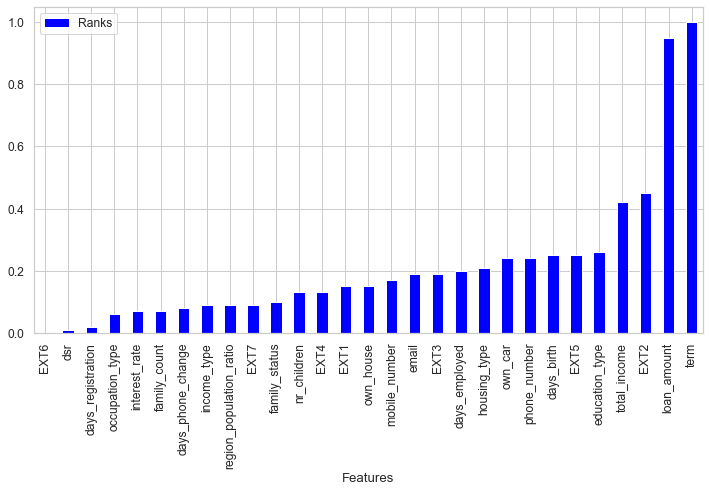

In [117]:
"""Plotting"""
import operator
listsBal = sorted(ranks["LogRegBalance"].items(), key=operator.itemgetter(1))
dfBal = pd.DataFrame(np.array(listsBal).reshape(len(listsBal), 2),
                     columns=['Features', 'Ranks']).sort_values('Ranks')
dfBal['Ranks'] = dfBal['Ranks'].astype(float)

dfBal.plot.bar(x='Features', y='Ranks', color='blue')
plt.xticks(rotation=90)
plt.show()

## XGB Classifier

In [118]:
## XGB Classifier
#Establish Model *Unhide to view output
"""
XGBClassifier - Feature Importance - PART 1
"""
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
print("Running XGBClassifier Feature Importance Part 1...")
model_XGBC = XGBClassifier(objective='binary:logistic',
                           max_depth=7, min_child_weight=5,
                           gamma=0,
                           learning_rate=0.1, n_estimators=100,)
# model_XGBC.fit(X_train, y_train)
model_XGBC.fit(std_data, y_train)
print("XGBClassifier Fitted")

"""Side To Side"""
print("Ranking Features with XGBClassifier...")
ranks["XGBC"] = rank_to_dict(model_XGBC.feature_importances_, names)
print(ranks["XGBC"])

Running XGBClassifier Feature Importance Part 1...
XGBClassifier Fitted
Ranking Features with XGBClassifier...
{'total_income': 0.59, 'loan_amount': 0.89, 'term': 1.0, 'interest_rate': 0.0, 'own_car': 0.45, 'own_house': 0.0, 'nr_children': 0.36, 'income_type': 0.47, 'education_type': 0.42, 'family_status': 0.44, 'housing_type': 0.44, 'region_population_ratio': 0.43, 'days_birth': 0.48, 'days_employed': 0.44, 'days_registration': 0.49, 'mobile_number': 0.46, 'phone_number': 0.46, 'email': 0.41, 'days_phone_change': 0.4, 'occupation_type': 0.46, 'family_count': 0.0, 'EXT1': 0.41, 'EXT2': 0.45, 'EXT3': 0.46, 'EXT4': 0.46, 'EXT5': 0.4, 'EXT6': 0.43, 'EXT7': 0.48, 'dsr': 0.5}


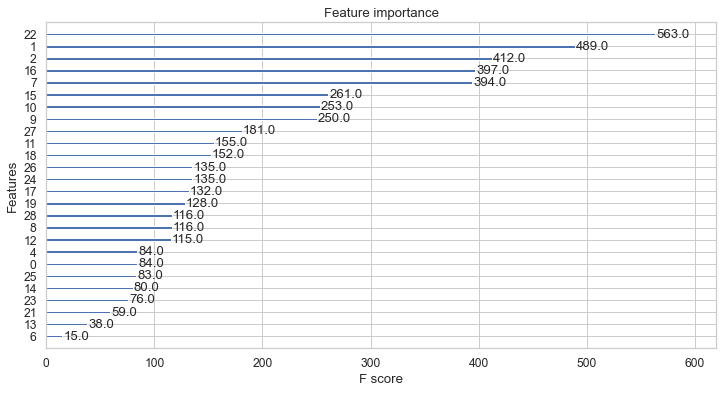

In [119]:
"""Plotting"""
# plot feature importance for feature selection using default inbuild function
plot_importance(model_XGBC)
plt.show()

## Coefficients for feature selection

In [120]:
"""
Collate Side to Side df - Feature Importance
"""

"""Quick Print Method"""
# Create empty dictionary to store the mean value calculated across all the scores
r = {}
for name in names:
    # This is the alternative rounding method from the earlier map & lambda combination
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)

methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

print("\t%s" % "\t".join(methods))
for name in names:
    print("%s\t%s" % (name, "\t".join(map(str, [ranks[method][name] for method in methods]))))

	LogRegBalance	LogRegLASSO	LogRegRidge	RFC	XGBC	model1	Mean
total_income	0.42	0.36	0.41	0.17	0.59	0.74	0.45
loan_amount	0.95	0.95	0.95	1.0	0.89	0.9	0.94
term	1.0	1.0	1.0	0.95	1.0	0.93	0.98
interest_rate	0.07	0.02	0.07	0.0	0.0	0.34	0.08
own_car	0.24	0.2	0.27	0.13	0.45	0.73	0.34
own_house	0.15	0.03	0.13	0.0	0.0	0.34	0.11
nr_children	0.13	0.09	0.15	0.02	0.36	0.6	0.23
income_type	0.09	0.04	0.08	0.52	0.47	0.36	0.26
education_type	0.26	0.17	0.23	0.16	0.42	0.9	0.36
family_status	0.1	0.05	0.11	0.3	0.44	0.4	0.23
housing_type	0.21	0.16	0.21	0.38	0.44	0.62	0.34
region_population_ratio	0.09	0.06	0.11	0.16	0.43	0.42	0.21
days_birth	0.25	0.18	0.24	0.19	0.48	0.68	0.34
days_employed	0.2	0.14	0.19	0.06	0.44	1.0	0.34
days_registration	0.02	0.0	0.0	0.13	0.49	0.22	0.14
mobile_number	0.17	0.12	0.16	0.32	0.46	0.59	0.3
phone_number	0.24	0.18	0.23	0.54	0.46	0.7	0.39
email	0.19	0.09	0.15	0.24	0.41	0.52	0.27
days_phone_change	0.08	0.02	0.05	0.19	0.4	0.34	0.18
occupation_type	0.06	0.02	0.08	0.17	0.46	0.29	0.18
f

In [121]:
"""Alternatively, Set into a df"""
# Loop through dictionary of scores to append into a dataframe
row_index = 0
AllFeatures_columns = ['Feature', 'Scores']
AllFeats = pd.DataFrame(columns=AllFeatures_columns)
for name in names:
        AllFeats.loc[row_index, 'Feature'] = name
        AllFeats.loc[row_index, 'Scores'] = [ranks[method][name] for method in methods]

        row_index += 1

# Here the dataframe scores are a list in a list.
# To split them, we convert the 'Scores' column from a dataframe into a list & back into a dataframe again
AllFeatures_only = pd.DataFrame(AllFeats.Scores.tolist(), )
# Now to rename the column headers
AllFeatures_only.rename(columns={0: 'LogRegBalance', 1: 'LogRegLASSO', 2: 'LogRegRidge',
                                 3: 'Random ForestClassifier', 4: 'XGB Classifier', 5: 'Mean'}, inplace=True)
AllFeatures_only = AllFeatures_only[['LogRegBalance', 'LogRegLASSO', 'LogRegRidge',
                                     'Random ForestClassifier', 'XGB Classifier', 'Mean']]
# Now to join both dataframes
AllFeatures_compare = AllFeats.join(AllFeatures_only).drop(['Scores'], axis=1)
display(AllFeatures_compare)

,Feature,LogRegBalance,LogRegLASSO,LogRegRidge,Random ForestClassifier,XGB Classifier,Mean
0,total_income,0.42,0.36,0.41,0.17,0.59,0.74
1,loan_amount,0.95,0.95,0.95,1.00,0.89,0.90
2,term,1.00,1.00,1.00,0.95,1.00,0.93
3,interest_rate,0.07,0.02,0.07,0.00,0.00,0.34
4,own_car,0.24,0.20,0.27,0.13,0.45,0.73
5,own_house,0.15,0.03,0.13,0.00,0.00,0.34
6,nr_children,0.13,0.09,0.15,0.02,0.36,0.60
7,income_type,0.09,0.04,0.08,0.52,0.47,0.36
8,education_type,0.26,0.17,0.23,0.16,0.42,0.90
9,family_status,0.10,0.05,0.11,0.30,0.44,0.40


C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



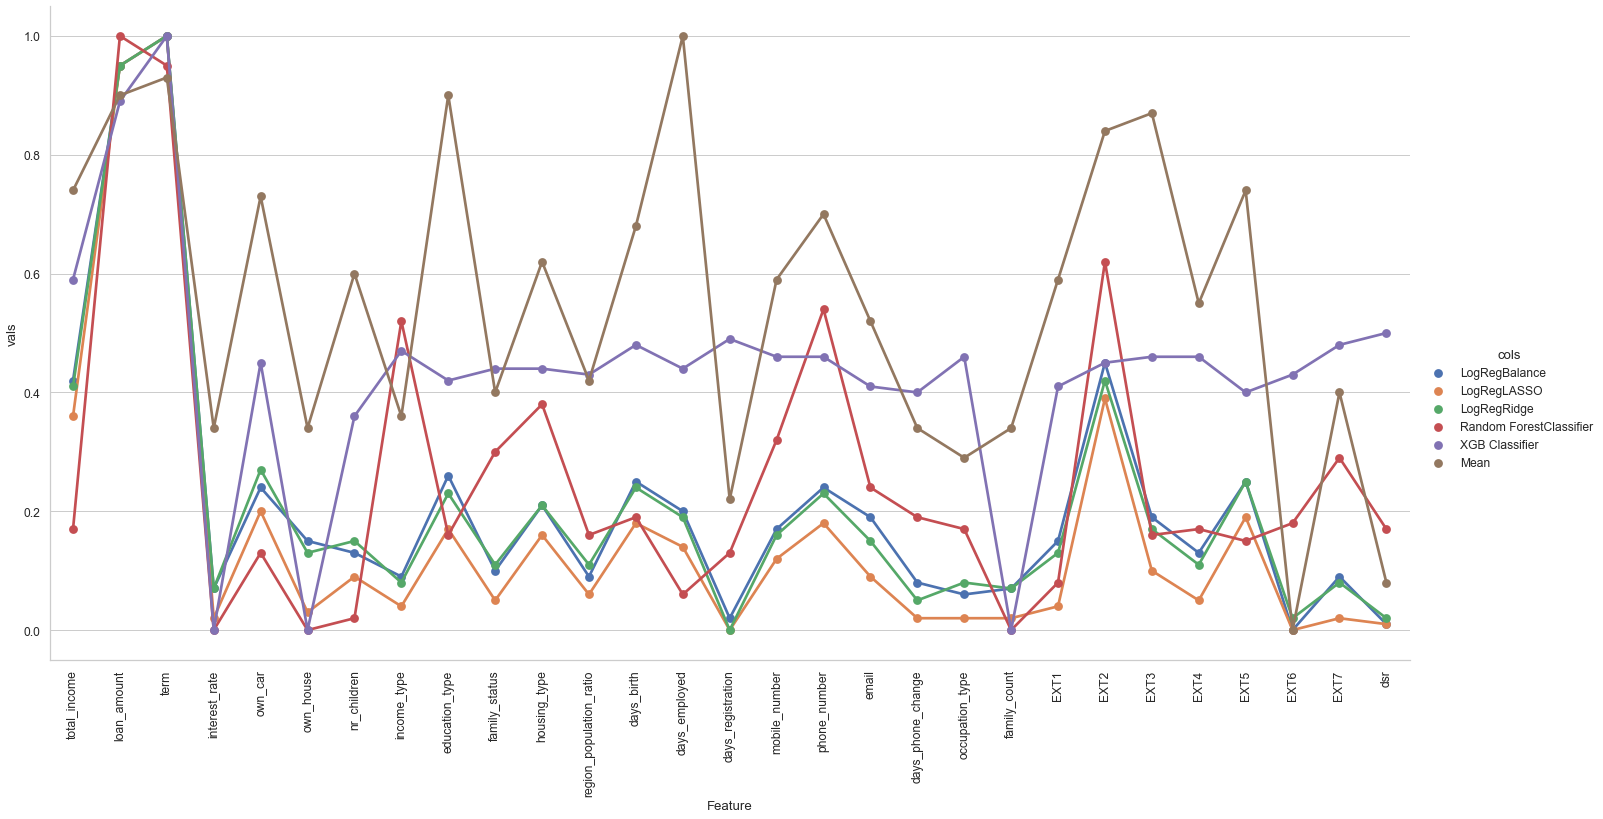

In [122]:
"""Quick Plotting"""
# Plotting
df = AllFeatures_compare.melt('Feature', var_name='cols',  value_name='vals')
g = sns.factorplot(x="Feature", y="vals", hue='cols', data=df, height=10, aspect=2)

plt.xticks(rotation=90)
plt.show()

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



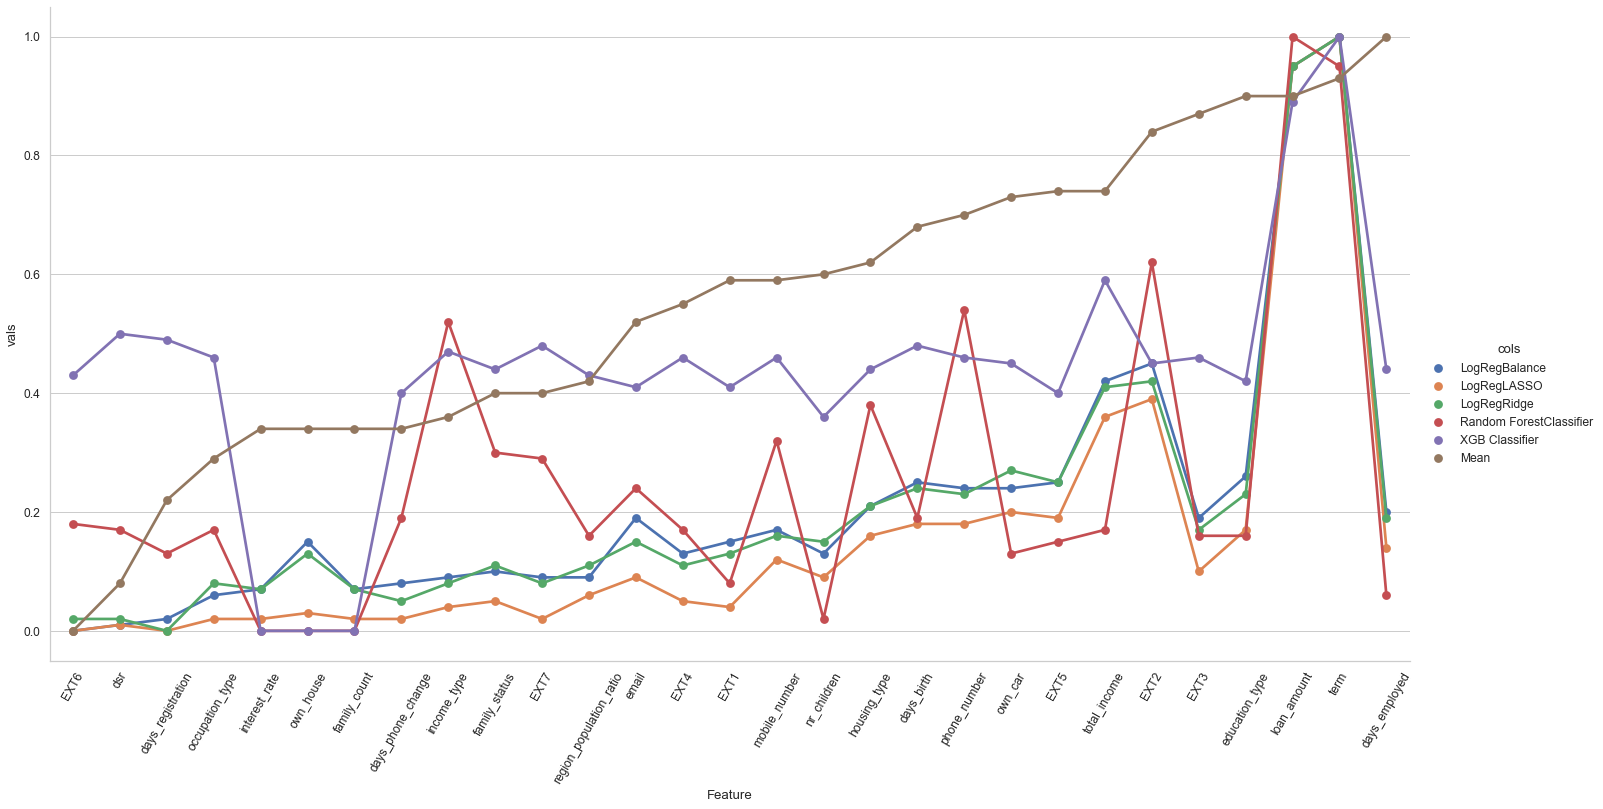

In [123]:
"""Sorted Plotting"""
AllFeatures_compare_sort = AllFeatures_compare.sort_values(by=['Mean'], ascending=True)
order_ascending = AllFeatures_compare_sort['Feature']
#Plotting
df2 = AllFeatures_compare_sort.melt('Feature', var_name='cols',  value_name='vals')
# ONLY Difference is that now we use row_order to sort based on the above ascending Ascending Mean Features
# g2 = sns.factorplot(x="Feature", y="vals", hue='cols', data=df2, size=10, aspect=2, row_order=order_ascending)
g2 = sns.factorplot(x="Feature", y="vals", hue='cols', data=df2, height=10, aspect=2, row_order=order_ascending)
plt.xticks(rotation=60)
plt.show()

## ROC Comparison

Charting ROC AUC for Ensembles...


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



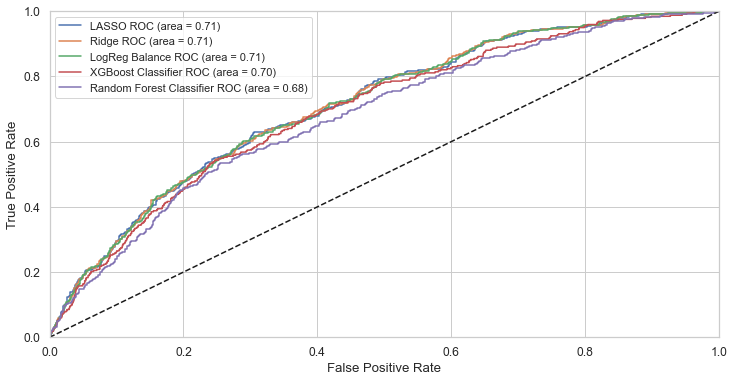

In [124]:
"""
Collate Side to Side df - ROC AUC
"""
# Ensemble Comparison of ROC AUC
from sklearn import model_selection
import matplotlib.pyplot as plt


print("Charting ROC AUC for Ensembles...")
from sklearn.metrics import roc_curve, auc

# Establish Models
models = [
    {
        'label': 'LASSO',
        'model': model_LogRegLASSO,
    },
    {
        'label': 'Ridge',
        'model': model_LogRegRidge,
    },
    {
        'label': 'LogReg Balance',
        'model': model_LogRegBalance,
    },
    {
        'label': 'XGBoost Classifier',
        'model': model_XGBC,
    },
    {
        'label': 'Random Forest Classifier',
        'model': model_RFC,
    }
]

# Models Plot-loop
for m in models:
    #fpr, tpr, thresholds = roc_curve(y_validation, m['model'].predict_proba(X_validation).T[1])
    scaler = StandardScaler()
    std_data2 = scaler.fit_transform(X_valid_woe.values)
    fpr, tpr, thresholds = roc_curve(y_valid, m['model'].predict_proba(std_data2).T[1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))

# Set Plotting attributes
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0, fontsize='small')
plt.show()

## Cross Validation

In [125]:
"""Collate Side to Side df - Accuracy Scores"""
# run model 10x with 60/30 split, but intentionally leaving out 10% avoiding overfitting
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=.3, train_size=.6, random_state=0)

# Ensemble Comparison of Accuracy Scores
# Set dataframe for appending``
# pd.options.display.max_columns = 100
ACCScores_columns = ['Model Name', 'Train Accuracy Mean', 'Test Accuracy Mean']
ACCScores_compare = pd.DataFrame(columns=ACCScores_columns)

In [126]:
# Models CV-loop
row_index = 0
for m in models:
    # Name of Model
    ACCScores_compare.loc[row_index, 'Model Name'] = m['label']

    # Execute Cross Validation (CV)
    cv_results = model_selection.cross_validate(m['model'], X_train_woe, y_train, cv=cv_split, return_train_score=True)
    # Model Train Accuracy
    ACCScores_compare.loc[row_index, 'Train Accuracy Mean'] = cv_results['train_score'].mean()
    # Model Test Accuracy
    ACCScores_compare.loc[row_index, 'Test Accuracy Mean'] = cv_results['test_score'].mean()

    row_index += 1

display(ACCScores_compare)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\uti

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\tools\Anacond

,Model Name,Train Accuracy Mean,Test Accuracy Mean
0,LASSO,0.914078,0.915993
1,Ridge,0.914183,0.916023
2,LogReg Balance,0.680201,0.681432
3,XGBoost Classifier,0.932694,0.912339
4,Random Forest Classifier,0.916684,0.916083


## Minimizing Operational Cost and Risk using IR and LGD

In [127]:
# Annuity
def A(am, ir_c, n):
    return am * (ir_c*(1+ir_c)**n) / ((1+ir_c)**n - 1)

# Present Value
def PV(A, ir_rf, n):
    return A * (1-1/((1+ir_rf)**n)) / ir_rf

# Future Value
def FV(am, ir, n):
    return am * (1+ir)**n

In [128]:
def cost_FP(am, n, ir_c, ir_rf=0.015):
    return PV(A(am,ir_c,n),ir_rf,n) - am

def cost_FN(am, lgd=0.75):
    return am*lgd

In [129]:
# compute cost matrix
# transform months -> years

cm_train = pd.DataFrame()
cm_train["cFP"] = cost_FP(X_train["loan_amount"], X_train["term"]/12, X_train["interest_rate"]/100)
cm_train["cFN"] = cost_FN(X_train["loan_amount"])
cm_train["cTP"] = 0.0
cm_train["cTN"] = 0.0
cm_train['diff'] = cm_train.cTP - cm_train.cFP
cm_train.sort_values( 'diff', ascending = False )[0:10]

cm_valid = pd.DataFrame()
cm_valid["cFP"] = cost_FP(X_valid["loan_amount"], X_valid["term"]/12, X_valid["interest_rate"]/100)
cm_valid["cFN"] = cost_FN(X_valid["loan_amount"])
cm_valid["cTP"] = 0.0
cm_valid["cTN"] = 0.0
cm_valid['diff'] = cm_valid.cTP - cm_valid.cFP
cm_valid.sort_values( 'diff', ascending = False )[0:10]

cm_test = pd.DataFrame()
cm_test["cFP"] = cost_FP(X_test["loan_amount"], X_test["term"]/12, X_test["interest_rate"]/100)
cm_test["cFN"] = cost_FN(X_test["loan_amount"])
cm_test["cTP"] = 0.0
cm_test["cTN"] = 0.0
cm_test['diff'] = cm_test.cTP - cm_test.cFP
cm_test.sort_values( 'diff', ascending = False )[0:10]

,cFP,cFN,cTP,cTN,diff
3489,-22482.165985,966262.5,0.0,0.0,22482.165985
10527,-9176.256252,1510380.0,0.0,0.0,9176.256252
5761,-6845.692538,808650.0,0.0,0.0,6845.692538
7556,-3885.826206,984082.5,0.0,0.0,3885.826206
4316,-3342.639405,1350000.0,0.0,0.0,3342.639405
8764,-1286.034117,808650.0,0.0,0.0,1286.034117
14794,-893.809564,1478304.0,0.0,0.0,893.809564
4166,-610.725396,840375.0,0.0,0.0,610.725396
5393,-286.600609,806949.0,0.0,0.0,286.600609
6939,9.272878,755190.0,0.0,0.0,-9.272878


In [130]:
cm_train.head()

,cFP,cFN,cTP,cTN,diff
9738,2098.514886,76410.0,0.0,0.0,-2098.514886
15328,35027.203130,444420.0,0.0,0.0,-35027.203130
14830,26492.368988,675000.0,0.0,0.0,-26492.368988
12186,3925.781377,347625.0,0.0,0.0,-3925.781377
9727,2232.272235,104422.5,0.0,0.0,-2232.272235


In [131]:
def total_cost(true, pred, cTP, cFN, cFP, cTN):
    return true*(pred*cTP+(1-pred)*cFN)+(1-true)*(pred*cFP+(1-pred)*cTN)

In [132]:
# Average cost
weights_avg_cost = {0:1, 1:np.mean(cm_train["cFN"] / cm_train["cFP"])}
print("Avg. cost:", weights_avg_cost)

# Inverse class distribution
#c0, c1 = np.digitize(y_train.iloc[:, 0], bins)
c0, c1 = np.bincount(np.ravel(y_train))
weights_inv = {0:1,1:c0/c1}
print("Inv. class distribution:", weights_inv)

Avg. cost: {0: 1, 1: 31.01288487392251}
Inv. class distribution: {0: 1, 1: 10.70241850683491}


In [133]:
# Class distribution
labels = ["Default - 0", "Default - 1"]
values = np.bincount(np.ravel(y_train))

print(X_train.shape, np.ravel(y_train).shape)
print(np.bincount(np.ravel(y_train)))

donut = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.5, marker_colors=["rgb(153, 214, 255)", "rgb(0, 92, 153)"])])
donut.show()

(11129, 58) (11129,)
[10178   951]


## Reject Inference Application

In [134]:
# Applying WOE
X_reject_woe=transf(reject)

In [135]:
# Keeping only the variables with the WOE value
X_reject_woe=X_reject_woe.loc[:, X_reject_woe.columns.str.contains('new')]

In [136]:
# Defining the cutoff rate
# Making predictions in the rejected dataset
prob_reject_lr = model1.predict_proba(X_reject_woe)
preds_reject_lr = pd.DataFrame(prob_reject_lr[:,1], columns = ['prob_default'])

In [137]:
# Defining the threshold for an acceptance rate of 15%
threshold = np.quantile(prob_reject_lr, 0.15)
threshold

0.2297230623740575

In [138]:
# Adding the predicted default status 
preds_reject_lr['Default'] = preds_reject_lr['prob_default'].apply(lambda x: 1 if x > threshold else 0)

In [139]:
# Combining training, accept and reject dataset for new model
y_reject=preds_reject_lr[["Default"]]
df_y=[y_train,y_valid,y_reject]
y_inference=pd.concat(df_y,axis=0)
X_train=X_train.iloc[:,0:27]
X_valid=X_valid.iloc[:,0:27]
X_reject=reject.iloc[:,0:27]
df_X=[X_train,X_valid,X_reject]
X_inference=pd.concat(df_X,axis=0)

In [140]:
# Applying the WOE and IV in the new training dataset
X_inference_pre = X_inference.drop('mobile_number', axis=1)
final_iv, IV = data_vars(X_inference_pre,y_inference.Default)

C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning:

divide by zero encountered in log



In [141]:
# Applying the new WOE in the new X_train and X_test datasets
X_test=X_test.iloc[:,0:27]
transform_vars_list = X_inference.columns.difference(['Default'])
transform_prefix = 'new_'

In [142]:
X_inference_woe= transf(X_inference)

In [143]:
X_test_woe= transf(X_test)

In [144]:
# Keeping only the variables with the WOE value
X_inference_woe=X_inference_woe.loc[:, X_inference_woe.columns.str.contains('new')]
X_test_woe=X_test_woe.loc[:, X_test_woe.columns.str.contains('new')]

In [145]:
reject.isnull().sum()

total_income                   0
loan_amount                    0
term                           0
interest_rate                  0
own_car                        0
own_house                      0
nr_children                    0
income_type                    0
education_type                 0
family_status                  0
housing_type                   0
region_population_ratio        0
days_birth                     0
days_employed                  0
days_registration              0
mobile_number                  0
phone_number                   0
email                          0
days_phone_change              0
occupation_type                0
family_count                   0
EXT1                           0
EXT2                           0
EXT3                           0
EXT4                           0
EXT5                           0
EXT6                           0
EXT7                           0
dsr                            0
new_EXT1                       0
new_EXT2  

In [146]:
# Defining Gradient Boosting model
gb = GradientBoostingClassifier()

# Create param grid
gbParam = {'learning_rate': [0.001,0.01, 0.05, 0.1],'max_features': ['auto', 'sqrt'],'max_depth' : [3,6,9]}

# Create grid search object
cv_gb = GridSearchCV(gb,gbParam, cv=3)

# Fit model 
best_gb = cv_gb.fit(X_inference_woe, np.ravel(y_inference))

In [147]:
# Making predictions in the test dataset
prob_lr_inf = best_gb.predict_proba(X_test_woe)
preds_lr_inf = pd.DataFrame(prob_lr_inf[:,1], columns = ['prob_default'])
preds_lr_inf['default_status'] = preds_lr_inf['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

'AUC_valid= 0.7389717743247604.'

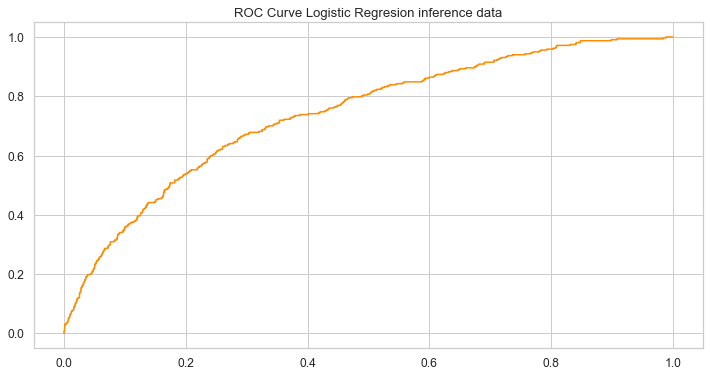

In [148]:
fallout, sensitivity, thresholds = roc_curve(y_test, preds_lr_inf['prob_default'])
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.title('ROC Curve Logistic Regresion inference data')

# Calculating the AUC in the test dataset
auc_lr_inf=roc_auc_score(y_test,preds_lr_inf['prob_default'])
f'AUC_valid= {auc_lr_inf}.'

## Using Logistic Regression

In [149]:
# Training a Logistic Regression over the X_inference dataset
lr_inf = LogisticRegression(**model_dict["logistic"].best_params_)
lr_inf.fit(X_inference_woe, np.ravel(y_inference))

LogisticRegression(C=0.25, class_weight='balanced', max_iter=200,
                   solver='liblinear')

In [150]:
# Making predictions in the test dataset
prob_lr_inf = lr_inf.predict_proba(X_test_woe)
preds_lr_inf = pd.DataFrame(prob_lr_inf[:,1], columns = ['prob_default'])
preds_lr_inf['default_status'] = preds_lr_inf['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

'AUC_valid= 0.7428171379003534.'

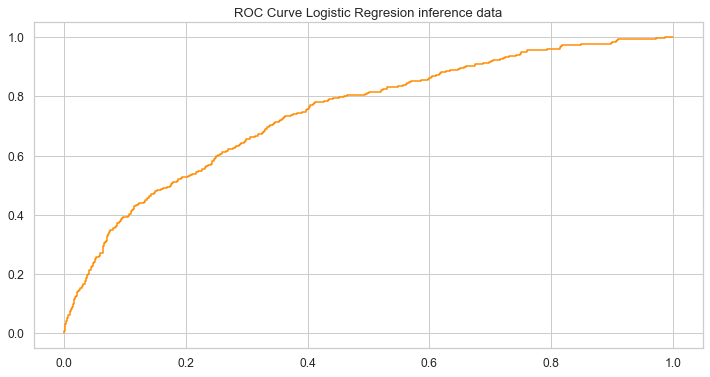

In [151]:
fallout, sensitivity, thresholds = roc_curve(y_test, preds_lr_inf['prob_default'])
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.title('ROC Curve Logistic Regresion inference data')

# Calculating the AUC in the test dataset
auc_lr_inf=roc_auc_score(y_test,preds_lr_inf['prob_default'])
f'AUC_valid= {auc_lr_inf}.'

In [152]:
# Create metrics evaluation report
target_names=['non_default','default']
print(classification_report(y_test, preds_lr_inf['default_status'], target_names=target_names))

              precision    recall  f1-score   support

 non_default       0.97      0.55      0.70      3393
     default       0.14      0.79      0.24       317

    accuracy                           0.57      3710
   macro avg       0.55      0.67      0.47      3710
weighted avg       0.90      0.57      0.66      3710



## Application of Scorecard

In [153]:
variables=X_inference_woe.columns
variables=pd.DataFrame(variables).rename({0:'variable'}, axis=1)
coef=lr_inf.coef_[0].tolist()
coef=pd.DataFrame(coef).rename({0:'coef'}, axis=1)
frames=[variables,coef]
df_coef_inf=pd.concat(frames, axis=1)
df_coef_inf

,variable,coef
0,new_EXT1,0.716458
1,new_EXT2,0.879386
2,new_EXT3,0.941921
3,new_EXT4,0.056911
4,new_EXT5,0.559745
5,new_EXT6,0.000009
6,new_days_birth,-0.096568
7,new_days_employed,0.830387
8,new_days_phone_change,0.010673
9,new_days_registration,0.534762


In [154]:
df_coef_inf['var']=df_coef_inf['variable'].apply(lambda x: x.split("new_")[1])
scorecard=final_iv[["VAR_NAME","MIN_VALUE","MAX_VALUE","WOE"]]
scorecard=pd.merge(scorecard,df_coef_inf,how="inner",left_on='VAR_NAME',right_on='var').drop(["variable","var"], axis=1)

In [155]:
alpha=lr_inf.intercept_[0]
score_df=pd.DataFrame(columns=["score"])
for i in list(range(len(scorecard))):
    score=(((scorecard.iloc[i, 4])*(scorecard.iloc[i, 3]))+(alpha/16))*(20/np.log(2)) + (600-((20/np.log(2))*np.log(50)))/16
    score_df=score_df.append({"score": score},ignore_index=True)

In [156]:
frames=[scorecard,score_df]
scorecard=pd.concat(frames,axis=1)

In [157]:
scorecard=scorecard.drop(["WOE","coef"],axis=1)

In [158]:
scorecard

,VAR_NAME,MIN_VALUE,MAX_VALUE,score
0,total_income,26550.0,153000.0,30.344351
1,total_income,153747.0,3600000.0,30.557529
2,loan_amount,45000.0,539100.0,29.746841
3,loan_amount,539230.5,4050000.0,31.170645
4,term,12.0,24.0,30.755658
...,...,...,...,...
120,EXT4,1,1,31.441205
121,EXT5,0,0,26.561068
122,EXT5,1,1,31.458362
123,EXT6,0,0,30.449979


## Conclusion

# References:

In [159]:
#https://towardsdatascience.com/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03
#https://www.kaggle.com/code/gpreda/home-credit-default-risk-extensive-eda
#https://www.kaggle.com/code/kabure/financial-hedging-eda-plotly-charts
#https://github.com/diode-meehai/WOE_IV/blob/main/My_credit_scoring_WOE_IV.ipynb
#https://www.kaggle.com/code/shivamb/homecreditrisk-extensive-eda-baseline-0-772
#https://github.com/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb
#https://www.kaggle.com/code/derrickchua29/feature-engineering-eda-focused
#https://www.kaggle.com/code/mammadabbasli/bank-marketing-campaign
#https://analyticsindiamag.com/complete-guide-to-lightgbm-boosting-algorithm-in-python/
#https://github.com/Feeledu
#https://github.com/klaudia-nazarko/iv-and-woe-python/blob/master/telco_customer_churn_analysis.ipynb
#https://github.com/vikrantpailkar/Credit_Score_Analysis/blob/master/Credit_Score_Analysis.ipynb
#https://pythonmana.com/2021/09/20210924134004607z.html